# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score, auc

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [3]:
def modelTestProcess(df, getdummy = 0,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        verboseprint(f'Classification report of {key}',':\n',value)
        verboseprint(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

%%html
<style>
.featname{
    color: red;
}
.numfont{
    color: aquamarine;
}
.catefont{
    color: Coral;
}
</style>

## **Data Exploration**

Dataset Source: [Prediction of music genre on kaggle](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre)

There are a total of 18 features in this dataset which are:

Data Description from the site:

|Feature Name|Description from the site|Data Type|
|:-:|-|:-:|
|<font class='featname'>instance_id</font>|unique ID for each music|<font class='numfont'>Numerical</font>|
|<font class='featname'>artist_name</font>|artist name|<font class='catefont'>Categorical</font>|
|<font class='featname'>track_name</font>|track name|<font class='catefont'>Categorical</font>|
|<font class='featname'>popularity</font>|how popular of this music|<font class='numfont'>Numerical</font>|
|<font class='featname'>acousticness</font>|acousticness|<font class='numfont'>Numerical</font>|
|<font class='featname'>danceability</font>|danceability|<font class='numfont'>Numerical</font>|
|<font class='featname'>duration_ms</font>|the duration of the music in ms|<font class='numfont'>Numerical</font>|
|<font class='featname'>energy</font>|energy|<font class='numfont'>Numerical</font>|
|<font class='featname'>instrumentalness</font>|instrumentalness|<font class='numfont'>Numerical</font>|
|<font class='featname'>key</font>|music key|<font class='catefont'>Categorical</font>|
|<font class='featname'>liveness</font>|liveness|<font class='numfont'>Numerical</font>|
|<font class='featname'>loudness</font>|loudness|<font class='numfont'>Numerical</font>|
|<font class='featname'>mode</font>|mode|<font class='catefont'>Categorical</font>|
|<font class='featname'>speechiness</font>|speechiness|<font class='numfont'>Numerical</font>|
|<font class='featname'>tempo</font>|tempo|<font class='numfont'>Numerical</font>|
|<font class='featname'>obtained_date</font>|date|<font class='catefont'>Date</font>|
|<font class='featname'>valence</font>|valence|<font class='numfont'>Numerical</font>|
|<font class='featname'>music_genre</font>|The full list of genres included in the CSV are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.|<font class='catefont'>Categorical</font>|

Number of instances: 50005  
Number of Attribute: 18

### **Import Dataset**

In [ ]:
dfOri = pd.read_csv('Data/music_genre.csv')
df = dfOri.copy()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

In [ ]:
df['duration_ms'].value_counts()

### **Overall Report**

In [ ]:
# dfProfile = df.copy()
# dfProfile.reset_index(drop=True, inplace=True)
# profile = pp.ProfileReport(dfProfile, title="Project Data Report", dark_mode=True)
# profile.config.html.style.primary_color = '#3CA2D3'
# if not os.path.exists(os.path.join(currDir, 'ProjectDataReport.html')):
#     profile.to_file('ProjectDataReport.html')
# profile.to_notebook_iframe()

### **Check and Remove Duplicates and Missing Values** 

In [ ]:
print(f"No. of Missing Values: {df.isna().any(axis=1).sum()}")
df[df.isna().any(axis=1)]

In [ ]:
print(f"No. of Duplicates: {df.duplicated().sum()}")
df[df.duplicated()==True]

In [ ]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

In [ ]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

In [ ]:
df.reset_index(drop=True, inplace=True)
df.info()

But from the report, we can see that there are some missing values in the dataset that we need to handle. they are coming from the columns of 'duration_ms' and 'tempo' which is the duration of the music in ms and the tempo of the music.

-   duration_ms: -1 is the missing value
-   tempo: "?" is the missing value

In [ ]:
idx = df[(df['tempo'] == '?')].index | df[(df['duration_ms'] == -1)].index
df_mis = df.loc[idx]
print(f"No. of Instances: {df_mis.shape[0]}")
print(f'Percentage of Instances: {round(df_mis.shape[0]/df.shape[0]*100, 2)}%')
df_mis.head()

In [ ]:
df['tempo'] = df['tempo'].apply(lambda x: np.nan if x == '?' else x) 
df['tempo'] = df['tempo'].astype(float)
df['duration_ms'] = df['duration_ms'].apply(lambda x: np.nan if x == -1 else x) 
df.info()

Since missing values are about 18.8% of the dataset, we decided not to remove them but to replace them with some valuse that we will discuss later in the data preprocessing section.

### **Remove Unnecessary Features**

In [ ]:
featuretoDrop = ['instance_id','artist_name','track_name','obtained_date']

In [ ]:
for feature in featuretoDrop:
    if feature in df.columns:
        df.drop(feature, axis=1, inplace=True)
print(f"No. of Features Left: {df.shape[1]}")

In [ ]:
df.info()

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features

**Separate Numerical Features from Dataset**

In [ ]:
dfNum = df.select_dtypes(include=['float64'])

**Separate Categorical Features from Dataset**

In [ ]:
dfCate = df.select_dtypes(include=['object'])

**Concatenate Separated Data**

In [ ]:
df = pd.concat([dfNum, dfCate], axis=1)

In [ ]:
df.info()

### **Plot Histograms and Value Count Charts**

In [ ]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

จากกราฟข้างต้น พบว่า Numerical features ส่วนใหญ่ไม่เป็น Normal distribution เช่น 'liveness' เเละ 'speechiness' ที่เป็น Right skewed distribution, 'energy' เเละ 'loudness' ที่เป็น Left skewed distribution ซึ่งเราจะทำการ Transform ในขั้นตอน Preprocessing เพื่อเปลี่ยนให้ Features เหล่านี้มีความเป็น Normal distribution มากขึ้น ซึ่งมีความสำคัญกับการ Train Model ในบาง Model เช่น Logistic Regression 

In [ ]:
CateDonut, axes = plt.subplots(1, 3, figsize=(20,20))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='w', lw=0.5),
          bbox=bbox_props, zorder=0, va="center")
for idx, col in enumerate(dfCate.columns):
    labelName = df[col].unique().tolist()
    wedges, texts = axes[idx].pie(df[col].value_counts(normalize=True)[df[col].unique()] * 100,
                                            startangle = 12,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
    axes[idx].set_title(col + " (Base)", pad=30)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        axes[idx].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[df[col].unique()][i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

เมื่อเราทดลอง Plot กราฟวงกลมออกมา เราพบว่า
- ในทุกเพลงของ Dataset นี้จะใช้คีย์ G มากที่สุดคิดเป็น 11.45% ของคีย์ทั้งหมด 12 คีย์ เเละใช้คีย์ D# น้อยที่สุดคิดเป็น 3.18% ของคีย์ทั้งหมด
- ในทุกเพลงของ Dataset นี้จะใช้ mode 'Major' มากกว่า 'Minor' คิดเป็น 64.20% ของเพลงทั้งหมด
- ใน Dataset นี้จะมีจำนวนเพลงในเเต่ละเเนวเพลงเท่ากัน คือเเนวเพลงทั้งหมด 10 เเนว เเนวเพลงละ 10% ของเพลงทั้งหมด 50000 เพลง หรือเเนวเพลงละ 5000 เพลง

### **Pairplotting Data Samples**

We will be pairplotting a tenth of the whole dataset to see the distribution of the data.

In [ ]:
# PairSamp, ax = plt.subplots(1, 1, figsize=(10, 10))
PairSamp = sns.pairplot(data = df.sample(int(df.shape[0]/10), random_state=777),
             diag_kind = 'kde',
             hue = 'music_genre',)
plt.setp(PairSamp._legend.get_title(), color=titleColor)
PairSamp.fig.suptitle("Pairplot of Sampled Data",
                      fontsize=16,
                      color=titleColor)
PairSamp.fig.subplots_adjust(top=0.95)

From the pairplot, we can see that the variance between class of the features are quite low and the variance within class of the features are quite low as well (except class 'Classical'). This means that the data is not very separable and we will need to use some feature engineering techniques to make the data more separable.

### **Plot Data for visualization**

In [ ]:
dfNum.columns

In [ ]:
df_visual = df.copy()
df_visual.columns

In [ ]:
def visualizationof2data(df, feature1, feature2, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    sum_group = df_visual_fcn[[feature2,feature1]].groupby(feature1).sum()
    mean_group  = df_visual_fcn[[feature2,feature1]].groupby(feature1).mean()
    # Plot
    visual_fcn_plot , axes = plt.subplots(1, 2, figsize=(20, 8))
    axes = axes.flatten()

    sns.barplot(x=sum_group[feature2], y=sum_group.index, ci=None, orient='h', ax=axes[0])
    axes[0].set_title(f'Total {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(sum_group[feature2]):
        if i in [1, 2, 3, 4]:
            axes[0].text(v+offset[0], i, '{}'.format(v), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
        else:
            axes[0].text(v+offset[1], i, '{}'.format(v), horizontalalignment='left', verticalalignment='center', weight='bold', color='black', fontsize=12)

    sns.barplot(x=mean_group[feature2], y=mean_group.index, ci=None, orient='h', ax=axes[1])
    axes[1].set_title(f'Average {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(mean_group[feature2]):
        axes[1].text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
    return visual_fcn_plot
# Example
# danceabilityByPopularityPlot = visualizationof2data(df_visual, 'popularity', 'danceability', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [ ]:
df_visual.mean()

In [ ]:
def visualizationof2dataAll(df, feature1, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    numcol = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
    numcol.remove(feature1)
    # Plot
    visual_fcn_plot, axes = plt.subplots(3, 4, figsize=(24, 20))
    for idx,col in enumerate(numcol):
        ax = axes[idx//4, idx%4]
        mean_group  = df_visual_fcn[[col,feature1]].groupby(feature1).mean()
        sns.barplot(x=mean_group[col], y=mean_group.index, ci=None, orient='h', ax=ax)
        ax.set_title(f'Average {col} \nby {feature1} Groups', weight='bold', fontsize=16)
        threshold = mean_group.max().values[0]
        for i,v in enumerate(mean_group[col]):
            # print(mean_group)
            # alignment
            if 2*mean_group.iloc[i].values[0] > threshold:
                halignment = 'right'
            else:
                halignment = 'left'
            ax.text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment=halignment, verticalalignment='center', weight='bold', color='black', fontsize=12)
    visual_fcn_plot.delaxes(axes[2,3])
    visual_fcn_plot.delaxes(axes[2,2])
    return visual_fcn_plot, mean_group

<h4>ยังไม่ได้ชำระข้อความ<h4>

In [ ]:
featureByPopularityPlot = visualizationof2dataAll(df_visual, 'popularity', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความ acousticness สูง จะมีความนิยมต่ำ
- เมื่อเพลงมีความ danceability สูง ความนิยมก็จะสูงขึ้นตาม
- เมื่อเพลงใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ความนิยมก็จะต่ำลง
- เพลงที่ค่า liveness ต่ำ จะมีความนิยมสูง
- เพลงที่มีความดังของเสียงสูง จะมีความนิยมต่ำ
- เพลงที่มีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) จะมีความนิยมสูง
- ความยาวของเพลง (duration_ms), ความพุ่งของเพลง (energy), จังหวะ (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับความนิยม

In [ ]:
featureByacousticnessPlot = visualizationof2dataAll(df_visual, 'acousticness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมต่ำ จะมีค่า acousticness สูง
- เมื่อเพลงมีความ danceability สูง ค่า acousticness จะต่ำ
- เมื่อเพลงมีความยาวสูง (duration_ms) ค่า acousticness จะสูง
- เมื่อเพลงมีความพุ่งของเพลง (energy) สูงขึ้น ค่า acousticness จะต่ำลง
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า acousticness จะสูง
- เพลงที่ค่า liveness สูง ค่า acousticness จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า acousticness จะสูง
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า acousticness จะต่ำลง
- เพลงที่มีจังหวะเร็ว (tempo) ค่า acousticness จะต่ำลง
- เพลงที่มีค่า valence สูง ค่า acousticness จะต่ำลง

In [ ]:
featureBydanceabilityPlot = visualizationof2dataAll(df_visual, 'danceability', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง จะมีค่า danceability สูง
- เมื่อเพลงมีความ danceability สูง ค่า acousticness จะต่ำ
- เมื่อเพลงมีความยาวสูง (duration_ms) ค่า danceability จะต่ำ
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า danceability จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า danceability จะต่ำ
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า danceability จะสูงขึ้น
- เพลงที่มีค่า valence สูง ค่า danceability จะสูงตาม
- ความพุ่งของเสียง (energy), เพลงที่บันทึกจากการแสดงสด (liveness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ danceability

In [ ]:
featureByenergyPlot = visualizationof2dataAll(df_visual, 'energy', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เมื่อเพลงมีค่า energy สูง ค่า acousticness จะต่ำ
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า energy จะต่ำ
- เพลงที่ค่า liveness สูง ค่า energy จะสูงตาม
- เพลงที่เสียงเบา (loudness) ค่า energy จะต่ำ
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า energy จะสูง
- เพลงที่มีจังหวะเร็ว (tempo) ค่า energy จะสูง
- เพลงที่มีค่า valence สูง ค่า energy จะสูง
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), เเละความยาวของเพลง (duration_ms) ไม่ค่อยมีความสัมพันธ์กับ danceability

In [ ]:
featureByinstrumentalnessPlot = visualizationof2dataAll(df_visual, 'instrumentalness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง ค่า instrumentalness จะต่ำ
- เพลงที่มีค่า acousticness สูง ค่า instrumentalness จะสูงตาม
- เพลงที่มีค่า danceability สูง ค่า instrumentalness จะต่ำ
- เมื่อเพลงมีค่า energy สูง ค่า instrumentalness จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า instrumentalness จะสูง
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า instrumentalness จะต่ำ
- เพลงที่มีจังหวะเร็ว (tempo) ค่า instrumentalness จะต่ำ
- เพลงที่มีค่า valence สูง ค่า instrumentalness จะต่ำ
- ความยาวของเพลง (duration_ms) เเละเพลงที่บันทึกจากการแสดงสด (liveness) ไม่ค่อยมีความสัมพันธ์กับ instrumentalness

In [ ]:
featureBylivenessPlot = visualizationof2dataAll(df_visual, 'liveness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง ค่า liveness จะต่ำ
- เพลงที่มีค่า danceability ต่ำ ค่า liveness จะสูง
- เพลงที่มีความยาว (duration_ms) สูง ค่า liveness จะสูง
- acousticness, energy, instrumentalness, loudness, speechiness, tempo, เเละ valence ไม่มีค่อยมีความสัมพันธ์กับ liveness

In [ ]:
featureByloudnessPlot = visualizationof2dataAll(df_visual, 'loudness', [-47, -40, -35, -30, -25, -20, -15, -5, 0, 4])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness ต่ำ ความดังของเสียงก็จะสูง
- เพลงที่มีค่า danceability สูง ความดังของเสียงก็จะสูง
- เมื่อเพลงมีค่า energy สูง ความดังของเสียงก็จะสูงตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ความดังของเสียงก็จะต่ำ
- เพลงที่ค่า liveness สูง ความดังของเสียงก็จะสูง
- เพลงที่มีเสียงร้องเยอะ (speechiness) ความดังของเสียงก็จะสูง
- เพลงที่มีจังหวะเร็ว (tempo) ความดังของเสียงก็จะสูงขึ้นตาม
- เพลงที่มีค่า valence สูง ความดังของเสียงก็จะสูง
- ความนิยมของเพลง (popularity) เเละความยาวของเพลง (duration_ms) ไม่ค่อยมีความสัมพันธ์กับ loudness

In [ ]:
featureByspeechinessPlot = visualizationof2dataAll(df_visual, 'speechiness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness สูง ค่า speechiness ก็จะสูง
- เพลงที่มีความยาวต่ำ ค่า speechiness ก็จะสูง
- เมื่อเพลงมีค่า energy สูง ค่า speechiness จะต่ำลง
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า speechiness จะต่ำ
- เพลงที่ค่า liveness สูง ค่า speechiness จะสูงขึ้นตาม
- เพลงที่มีเสียงดัง (loudness) ค่า speechiness จะลดต่ำลง ????
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), จังหวะเพลง (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ speechiness

In [ ]:
featureBytempoPlot = visualizationof2dataAll(df_visual, 'tempo', [34, 53, 72, 91, 110, 129, 148, 167, 186, 205])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness สูง ค่า tempo ก็จะต่ำ
- เมื่อเพลงมีค่า energy สูง ค่า tempo ก็จะสูงตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงน้อย (instrumentalness) ค่า tempo จะสูง
- เพลงที่มีเสียงดัง (loudness) ค่า tempo จะสูง
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), ความยาวเพลง (duration_ms), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ tempo

In [ ]:
featureByvalencePlot = visualizationof2dataAll(df_visual, 'valence', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความ acousticness สูง ค่า valence จะต่ำ
- เมื่อเพลงมีความ danceability สูง ค่า valence จะสูงขึ้นตาม
- เมื่อเพลงมีความยาวมากขึ้น (duration_ms) ค่า valence จะลดลง
- เมื่อเพลงมีความพุ่งของเพลง (energy) สูงขึ้น ค่า valence จะสูงขึ้นตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า valence จะต่ำ
- เพลงที่เสียงเบา ค่า valence จะต่ำ
- ความนิยม (popularity), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ valence

### **Plot Outlier for visualization**

In [ ]:
def plotoutlierBarStrip(df,title='',plottype='both',plotdetail='notdetail'):
    df_def = df.copy()
    plotlist = []
    if plottype == 'both' or plottype == 'box':
        if plotdetail == 'notdetail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphBox.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphBox.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.boxplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.boxplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (box)')
        plotlist.append(plotgraphBox)
    if plottype == 'both' or plottype == 'strip':
        if plotdetail == 'notdetail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphStrip.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphStrip.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.stripplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.stripplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (strip)')
        plotlist.append(plotgraphStrip)
    return plotlist

In [ ]:
outlierplotALL = plotoutlierBarStrip(df_visual,'','both','notdetail')

In [ ]:
outlierplotBoxDetail = plotoutlierBarStrip(df_visual,'','box','detail')

In [ ]:
outlierplotstripdetail = plotoutlierBarStrip(df_visual,'','strip','detail')

โดยเราจะเห็นได้ว่ามี Outlier อยู่ใน Data set ของเรายิ่งโดยจะเห็นได้ชัดใน Feature duration_ms มากที่สุด

### **Data Exploration's Conclusion**

To conclude everything up to this point, there were <u>4 unnecessary feature</u>, <u>4 duplicated instances</u> and <u>1 missing values</u> that we have removed. This means that we are left with a total of **50000 instances and 14 features**.

In which, there are:

- 4 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 10 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'

In [ ]:
df.to_csv('Data/data.csv', index=False)

## **Data Preprocessing**

In [ ]:
df = pd.read_csv('Data/data.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

### **Handle Missing Values**

เนื่องจาก Missing values มีจำนวนมาก 18.8% ของ Dataset ทั้งหมด จึงเลือกที่จะ Replace แทนที่จะ Remove โดยเลือกที่จะ Replace ด้วยค่าต่างในการทดลองนี้โดยเราพิจารณาใช้

- ค่าเฉลี่ยของคอลัมน์ที่มี Missing values
- ค่าที่มีความถี่สูงสุดของคอลัมน์ที่มี Missing values
- Multivariate Imputation by Chained Equations(mice)
- K-Nearest Neighbors (KNN) Imputer

In [ ]:
df_vis = df.copy()
df_impute =  df.copy()

In [ ]:
def plotForImpute(df, feature, df2 = None, prefix = ['','']):
    df = df.copy()
    df_Electronic = df[df['music_genre'] == 'Electronic']
    df_Anime = df[df['music_genre'] == 'Anime']
    df_Jazz = df[df['music_genre'] == 'Jazz']
    df_Alternative = df[df['music_genre'] == 'Alternative']
    df_Country = df[df['music_genre'] == 'Country']
    df_Blues = df[df['music_genre'] == 'Blues']
    df_Rap = df[df['music_genre'] == 'Rap']
    df_Rock = df[df['music_genre'] == 'Rock']
    df_Classical = df[df['music_genre'] == 'Classical']
    df_Hip_Hop = df[df['music_genre'] == 'Hip-Hop']
    if type(df2) == type(None):
        plotDflist = [df_Electronic, df_Anime, df_Jazz, df_Alternative, df_Country, df_Blues, df_Rap, df_Rock, df_Classical, df_Hip_Hop]
        titlelist = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Blues', 'Rap', 'Rock', 'Classical', 'Hip-Hop']
        row , col = 2, 5
        targetPlot = feature
        imputeHists, axes = plt.subplots(row, col, figsize=(30, 10))
    else :
        df2 = df2.copy()
        df2_Electronic = df2[df2['music_genre'] == 'Electronic']
        df2_Anime = df2[df2['music_genre'] == 'Anime']
        df2_Jazz = df2[df2['music_genre'] == 'Jazz']
        df2_Alternative = df2[df2['music_genre'] == 'Alternative']
        df2_Country = df2[df2['music_genre'] == 'Country']
        df2_Blues = df2[df2['music_genre'] == 'Blues']
        df2_Rap = df2[df2['music_genre'] == 'Rap']
        df2_Rock = df2[df2['music_genre'] == 'Rock']
        df2_Classical = df2[df2['music_genre'] == 'Classical']
        df2_Hip_Hop = df2[df2['music_genre'] == 'Hip-Hop']
        plotDflist = [df_Electronic, df2_Electronic, df_Anime, df2_Anime, df_Jazz, df2_Jazz, df_Alternative, df2_Alternative, df_Country, df2_Country, df_Blues, df2_Blues, df_Rap, df2_Rap, df_Rock, df2_Rock, df_Classical, df2_Classical, df_Hip_Hop, df2_Hip_Hop]
        titlelist = ['Electronic', 'Electronic', 'Anime', 'Anime', 'Jazz', 'Jazz', 'Alternative', 'Alternative', 'Country', 'Country', 'Blues', 'Blues', 'Rap', 'Rap', 'Rock', 'Rock', 'Classical', 'Classical', 'Hip-Hop', 'Hip-Hop']
        row , col = 5, 2
        targetPlot = feature
        imputeHists, axes = plt.subplots(2*row, col, figsize=(20, 60))
    for i, df in enumerate(plotDflist):
            ax = axes[i//col, i%col]
            sns.histplot(df[targetPlot], ax=ax, color=snsPalette[0], kde=True)
            if i%2 == 0:
                ax.set_title(f'{prefix[0]}'+titlelist[i])
            else:
                ax.set_title(f'{prefix[1]}'+titlelist[i])
            ax.set_xlabel(targetPlot)
            ax.set_ylabel('Count')
            ax.set_facecolor(axBGColor)
    return imputeHists

#### **Plotting Histogram**

In [ ]:
imputeHists_tempo = plotForImpute(df_vis, 'tempo')

In [ ]:
imputeHists_duration_ms = plotForImpute(df_vis, 'duration_ms')

โดยเราจะ Plot Histogram ของคอลัมน์ที่มี Missing values ออกมาเพื่อพิจารณาการกระจายของตัวของข้อมูล โดยเราจะพยายามที่จะเลือก Method ในการ Replace ที่มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุดเพื่อไม่ให้การทำ Imputation ทำให้ข้อมูลไมาแสดงถึงการกระจายของข้อมูลจริง 

#### **Imputation Using Mean,Most Frequent**

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute_mean = df_impute.copy()
df_impute_mean['tempo'] = imp_mean.fit_transform(df_impute_mean[['tempo']])
df_impute_mean['duration_ms'] = imp_mean.fit_transform(df_impute_mean[['duration_ms']])
imputeHists_mean_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mean, ['Original ','Imputed '])
imputeHists_mean_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mean, ['Original ','Imputed '])

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_impute_mode = df_impute.copy()
df_impute_mode['tempo'] = imp_mode.fit_transform(df_impute_mode[['tempo']])
df_impute_mode['duration_ms'] = imp_mode.fit_transform(df_impute_mode[['duration_ms']])
imputeHists_mode_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mode, ['Original ','Imputed '])
imputeHists_mode_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mode, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is not quite the same as before. So we decided not to use the mean and the most frequent value to impute the missing values.

#### **Imputation Using Multivariate Imputation by Chained Equations(mice)**

In [ ]:
from impyute.imputation.cs import mice

df_impute_mice = df_impute.copy()
df_impute_mice.drop(['key','mode','music_genre'], axis=1, inplace=True)
imputed_training=mice(df_impute_mice.values)

In [ ]:
df_impute_mice = pd.DataFrame(imputed_training, columns=df_impute_mice.columns)
df_impute_mice['key'] = df_impute['key']
df_impute_mice['mode'] = df_impute['mode']
df_impute_mice['music_genre'] = df_impute['music_genre']
df_impute_mice

In [ ]:
imputeHists_mice_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mice, ['Original ','Imputed '])

In [ ]:
imputeHists_mice_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mice, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the mice to impute the missing values.

#### **Imputation Using KNNImputer**

##### **Search for Hyperparameter**

In [ ]:
# Impute missing values
df_impute_knn_find = df_impute.copy()
df_impute_knn_find = pd.get_dummies(df_impute_knn_find, columns=['key','mode'], drop_first=True).dropna()

In [ ]:
X = df_impute_knn_find.drop(['music_genre'], axis=1)
y = df_impute_knn_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scaler = StandardScaler()
X = scaler.fit_transform(X)

KN_param = [{ 'n_neighbors' : range(0,6,1),
             'weights' : ['uniform', 'distance'],
              }]

KN_clf = KNeighborsClassifier(n_jobs=-1)

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_clf = GridSearchCV(KN_clf, 
                        KN_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [ ]:
# grid_KN_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_clf.best_params_)
# print("score :",grid_KN_clf.best_score_)

"""
Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'uniform'}
score : 0.41099356419921224

Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}
score : 0.4450642884772404

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 10, 'weights': 'uniform'}
score : 0.4686828275311239

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 30, 'weights': 'uniform'}
score : 0.4754055746692795
"""

โดยหลังจากที่นำค่า K ที่เป็นไปได้มาทดลองแล้ว จะพบว่า ค่า K ที่ดีที่สุดคือ 3 ที่จะใช้ Histogram ในการทำ Imputation ให้มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุด ทั้งนี้ด้วยความที่ KNN เป็น Model ที่ได้รับผลกระทบจาก Outlier ค่อนข้างมากเมื่อ K เพิ่มขึ้น ด้วยเหตุที่ว่า มี Bias ที่สูงและ Variance ที่ต่ำ จึงเลือกใช้ K ที่เล็กที่สุด 3 ในการทำ Imputation

##### **Impute**

In [ ]:
# Impute missing values
df_impute_knn = df_impute.copy()
df_impute_knn = pd.get_dummies(df_impute_knn, columns=['key','mode','music_genre'], drop_first=True)
col_knn = df_impute_knn.columns

In [ ]:
scaler_knnimpute = StandardScaler()
df_impute_knn = pd.DataFrame(scaler_knnimpute.fit_transform(df_impute_knn), columns=col_knn)
KNNimputer = KNNImputer(n_neighbors=3, weights="uniform")
df_impute_knn = pd.DataFrame(KNNimputer.fit_transform(df_impute_knn), columns=col_knn)
df_impute_knn = pd.DataFrame(scaler_knnimpute.inverse_transform(df_impute_knn), columns=col_knn)

In [ ]:
duration_ms = df_impute_knn['duration_ms']
tempo = df_impute_knn['tempo']
df_impute_knn = df_impute.copy()
df_impute_knn['duration_ms'] = duration_ms
df_impute_knn['tempo'] = tempo
df_impute_knn

In [ ]:
imputeHists_KNN_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_knn, ['Original ','Imputed '])

In [ ]:
imputeHists_KNN_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_knn, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the KNNImputer to impute the missing values.

#### **Conclusion**

เนื่องจากการทำ Imputation ด้วย KNNImputer และ mice ได้ผลลัพธ์ที่ใกล้เคียงกับข้อมูลตั้งต้นมาก เราจะพิจารณาถึง Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลเพิ่มเติม

In [ ]:
coltoplot = ['duration_ms','tempo']
dftoplot = [df_vis, df_impute_mice, df_impute_knn]
titlelist = ['Original','MICE','KNN']
NumHists_knn, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, df in enumerate(dftoplot):
    for j, col in enumerate(coltoplot):
        ax = axes[j, i]
        sns.histplot(df[col], ax=ax, color=snsPalette[0], kde=True)
        ax.set_title(f'{col} '+titlelist[i])
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_facecolor(axBGColor)

In [ ]:
outlierplotstripOriginal = plotoutlierBarStrip(df_vis, 'Original','strip','notdetail')

In [ ]:
outlierplotstripMice = plotoutlierBarStrip(df_impute_mice, 'KNN Impute','strip','notdetail')

In [ ]:
outlierplotstripKNNimpute = plotoutlierBarStrip(df_impute_knn, 'KNN Impute','strip','notdetail')

หลังจากพิจารณา Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลแล้วพอว่าผลลัพธ์ที่ได้จากการทำ Imputation ด้วย KNNImputer มีความถูกต้องมากกว่าการทำ Imputation ด้วย Mean, Most Frequent และ mice จึงเลือกใช้ KNNImputer ในการทำ Imputation เป็นผลลัพธ์สุดท้าย

In [ ]:
df_impute_knn.to_csv('Data/df_impute_knn.csv', index=False)

### **Remove Outlier**

In [4]:
df = pd.read_csv('Data/df_impute_knn.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])
dfOutlier = df.copy()
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic


##### **Performance Benchmark**

In [5]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

Logistic Regression Model (F1 score) : 0.524447965191827
Decision Tree Model (F1 score) : 0.44075530167155413
Random Forest Model (F1 score) : 0.5471645226550553
KNN Model (F1 score) : 0.47193630572630274
MLPC Model (F1 score) : 0.5821545904941349


We will be removing the outliers from the dataset using Anomaly Detection with Isolation Forest Algorithm, Local Outlier Factor Algorithm and KNN Algorithm.

#### **Isolation Forest**

In [6]:
dfOutlier_IF = dfOutlier.copy()
dfOutlier_IF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


##### **Search for Hyperparameter**

In [7]:
def IFparamtuning(df,param,getdummy=0,verbose=0,n_estimators=[100],contamination=['auto'],max_features=[1.0]):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    iteration = 1
    bestscore = 0
    bestmodel = None
    bestparam = None
    classreport = None
    print(f'All parameters are {param}') 
    for key, value in param.items():
        if key == 'n_estimators':
            n_estimators = value
        elif key == 'contamination':
            contamination = value
        elif key == 'max_features':
            max_features = value
    print(f'Number of Iteration: {len(n_estimators)*len(contamination)*len(max_features)}')
    print('-'*50)
    for i in n_estimators:
        for j in contamination:
            for k in max_features:
                verboseprint(f'Iteration number :{iteration}')
                verboseprint(f'n_estimators = {i}, contamination = {j}, max_features = {k}')
                IF_clf = IsolationForest(n_estimators=i, contamination=j, max_features=k, n_jobs=-1, random_state=1)
                IF_clf.fit(X)
                df_model['anomaly'] = IF_clf.predict(X)
                outliers = df_model[df_model['anomaly'] == -1]
                outlier_index = list(outliers.index)
                verboseprint(f'Number of outliers is {len(outlier_index)}')
                df_score = df_model[df_model['anomaly'] == 1].drop(['anomaly'], axis=1)
                df_model = df_model.drop('anomaly', axis=1)
                RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
                X_score = df_score.drop(['music_genre'], axis=1)
                y_score = df_score['music_genre']
                # Scaling
                scalerScore = StandardScaler()
                X_score = scalerScore.fit_transform(X_score)
                # Splitting
                X_train, X_test, y_train, y_test = train_test_split(X_score, y_score, test_size=0.2, random_state=1)
                # Training
                RF_clf = RF_clf.fit(X_train, y_train)
                # Testing
                y_pred = RF_clf.predict(X_test)
                f1score = f1_score(y_test, y_pred, average='weighted')
                classreport = classification_report(y_test, y_pred)
                verboseprint(f'F1 score of Random Forest Model is {f1score}\n','-'*50)
                if f1score > bestscore:
                    bestscore = f1score
                    bestparam = {'n_estimators':i,'contamination':j,'max_features':k}
                    bestmodel = IF_clf
                iteration += 1
    print(f'Best score is {bestscore} with parameters {bestparam}')
    print(f'Best model is {bestmodel}')
    return bestparam,classreport,bestmodel

In [8]:
""""
'n_estimators':list(range(10,110,10))
'contamination':['auto',0.01, 0.02, 0.03]
Best score is 0.5538827260767094 with parameters {'n_estimators': 20, 'contamination': 0.01, 'max_features': 1.0}
Best model is IsolationForest(contamination=0.01, n_estimators=20, n_jobs=-1, random_state=1)

{'n_estimators':[20],
'contamination':[0.01],
'max_features':list(range(1,21,1))
Best score is 0.55187532899251 with parameters {'n_estimators': 20, 'contamination': 0.01, 'max_features': 2}
Best model is IsolationForest(contamination=0.01, max_features=2, n_estimators=20, n_jobs=-1,
                random_state=1)
"""
# list(range(10,110,10))
# parm,rep,mo = IFparamtuning(dfOutlier_IF,{'n_estimators':[10, 20, 30, 40, 50],
#                                         'contamination':['auto',0.01, 0.02, 0.03],
#                                         getdummy=1,
#                                         verbose=1)
pass

In [9]:
dfOutlier_IF_find = dfOutlier_IF.copy()
dfOutlier_IF_find = pd.get_dummies(dfOutlier_IF_find, columns=['key','mode'],drop_first=True)
X = dfOutlier_IF_find.drop(['music_genre'], axis=1)
y = dfOutlier_IF_find['music_genre']
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))

IF_clf = IsolationForest(n_jobs=-1, random_state=1)

minrange =10
maxrange = 110
step = 10
param_grid = {
              # 'n_estimators': list(range(minrange,maxrange,step)), 
              # 'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              # 'max_features': [15,20],
              }

scoring = {'f1score':make_scorer(f1_score,average='weighted')}
# scoring = {'Recall': make_scorer(recall_score, pos_label=-1, average='weighted')
#           ,'f1score': make_scorer(f1_score, pos_label=-1, average='weighted')}
# ,'AUC': make_scorer(roc_auc_score,
#                                 average='weighted',
#                                 multi_class='ovr',
#                                 labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}                                       

grid_dt_estimator = GridSearchCV(IF_clf, 
                                param_grid,
                                scoring=scoring, 
                                refit='f1score',
                                cv=4,
                                n_jobs=-1,
                                return_train_score=True
                                )

In [10]:
'''

Fitting 4 folds for each of 15 candidates, totalling 60 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 140}
score : 0.05262386217850815

Fitting 4 folds for each of 18 candidates, totalling 72 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 150}
score : 0.05270171149144254

Fitting 4 folds for each of 20 candidates, totalling 80 fits
tuned hpyerparameters :(best parameters)  {'max_features': 20, 'n_estimators': 100}
score : 0.05414193867457961

'''
# grid_dt_estimator.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_dt_estimator.best_params_)
# print("score :",grid_dt_estimator.best_score_)
# results = grid_dt_estimator.cv_results_
pass

##### **Remove outlier**

In [11]:
X = dfOutlier_IF.copy()
y = X['music_genre']
X = pd.get_dummies(X, columns=['key','mode'], drop_first=True).drop(['music_genre'], axis=1)
scaler_IF = StandardScaler()
X = scaler_IF.fit_transform(X)

In [12]:
IF_clf = IsolationForest(n_estimators=20, contamination=0.01, n_jobs=-1, random_state=1)
IF_clf = IF_clf.fit(X,y)

In [13]:
dfOutlier_IF['anomalyscore'] = IF_clf.score_samples(X)
dfOutlier_IF['anomaly']= IF_clf.predict(X)
dfOutlier_IF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre,anomalyscore,anomaly
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic,-0.483615,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic,-0.517061,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic,-0.450166,1
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic,-0.378085,1
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic,-0.517650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop,-0.407122,1
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop,-0.490252,1
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop,-0.427725,1
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop,-0.419981,1


In [14]:
outliers=dfOutlier_IF.loc[dfOutlier_IF['anomaly']==-1]
outlier_index=list(outliers.index)
print(dfOutlier_IF['anomaly'].value_counts())
outliers

 1    49500
-1      500
Name: anomaly, dtype: int64


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre,anomalyscore,anomaly
288,34.0,0.01420,0.569,159880.0,0.988,0.920000,0.6320,-4.021,0.3760,126.150333,0.1420,F#,Minor,Electronic,-0.552367,-1
373,46.0,0.71600,0.589,366970.0,0.587,0.845000,0.1000,-14.527,0.3080,149.024000,0.5680,F#,Minor,Electronic,-0.580265,-1
614,37.0,0.00161,0.889,860761.0,0.480,0.835000,0.0514,-12.380,0.0747,100.002000,0.0751,A#,Minor,Electronic,-0.569811,-1
695,35.0,0.49400,0.247,207960.0,0.296,0.049100,0.0763,-13.472,0.0437,184.154000,0.1230,B,Minor,Electronic,-0.572137,-1
854,34.0,0.00519,0.621,274467.0,0.903,0.930000,0.1210,-9.548,0.1390,107.002000,0.5250,F#,Major,Electronic,-0.552307,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48252,64.0,0.81900,0.471,243724.0,0.784,0.000011,0.1070,-8.250,0.8830,160.833000,0.2580,B,Minor,Hip-Hop,-0.568867,-1
49083,60.0,0.71400,0.802,206811.0,0.616,0.000000,0.0929,-9.740,0.7120,91.894000,0.6060,D,Major,Hip-Hop,-0.553294,-1
49430,48.0,0.79300,0.589,52907.0,0.391,0.000000,0.9320,-15.681,0.9320,89.046000,0.7210,F#,Minor,Hip-Hop,-0.577240,-1
49650,53.0,0.47000,0.633,59118.0,0.506,0.000000,0.9590,-16.808,0.8630,112.074667,0.7840,C#,Major,Hip-Hop,-0.557180,-1


In [15]:
df_outliertest_IF = dfOutlier_IF[dfOutlier_IF['anomaly']==1].drop(['anomaly','anomalyscore'], axis=1)
df_outliertest_IF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49500 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        49500 non-null  float64
 1   acousticness      49500 non-null  float64
 2   danceability      49500 non-null  float64
 3   duration_ms       49500 non-null  float64
 4   energy            49500 non-null  float64
 5   instrumentalness  49500 non-null  float64
 6   liveness          49500 non-null  float64
 7   loudness          49500 non-null  float64
 8   speechiness       49500 non-null  float64
 9   tempo             49500 non-null  float64
 10  valence           49500 non-null  float64
 11  key               49500 non-null  object 
 12  mode              49500 non-null  object 
 13  music_genre       49500 non-null  object 
dtypes: float64(11), object(3)
memory usage: 5.7+ MB


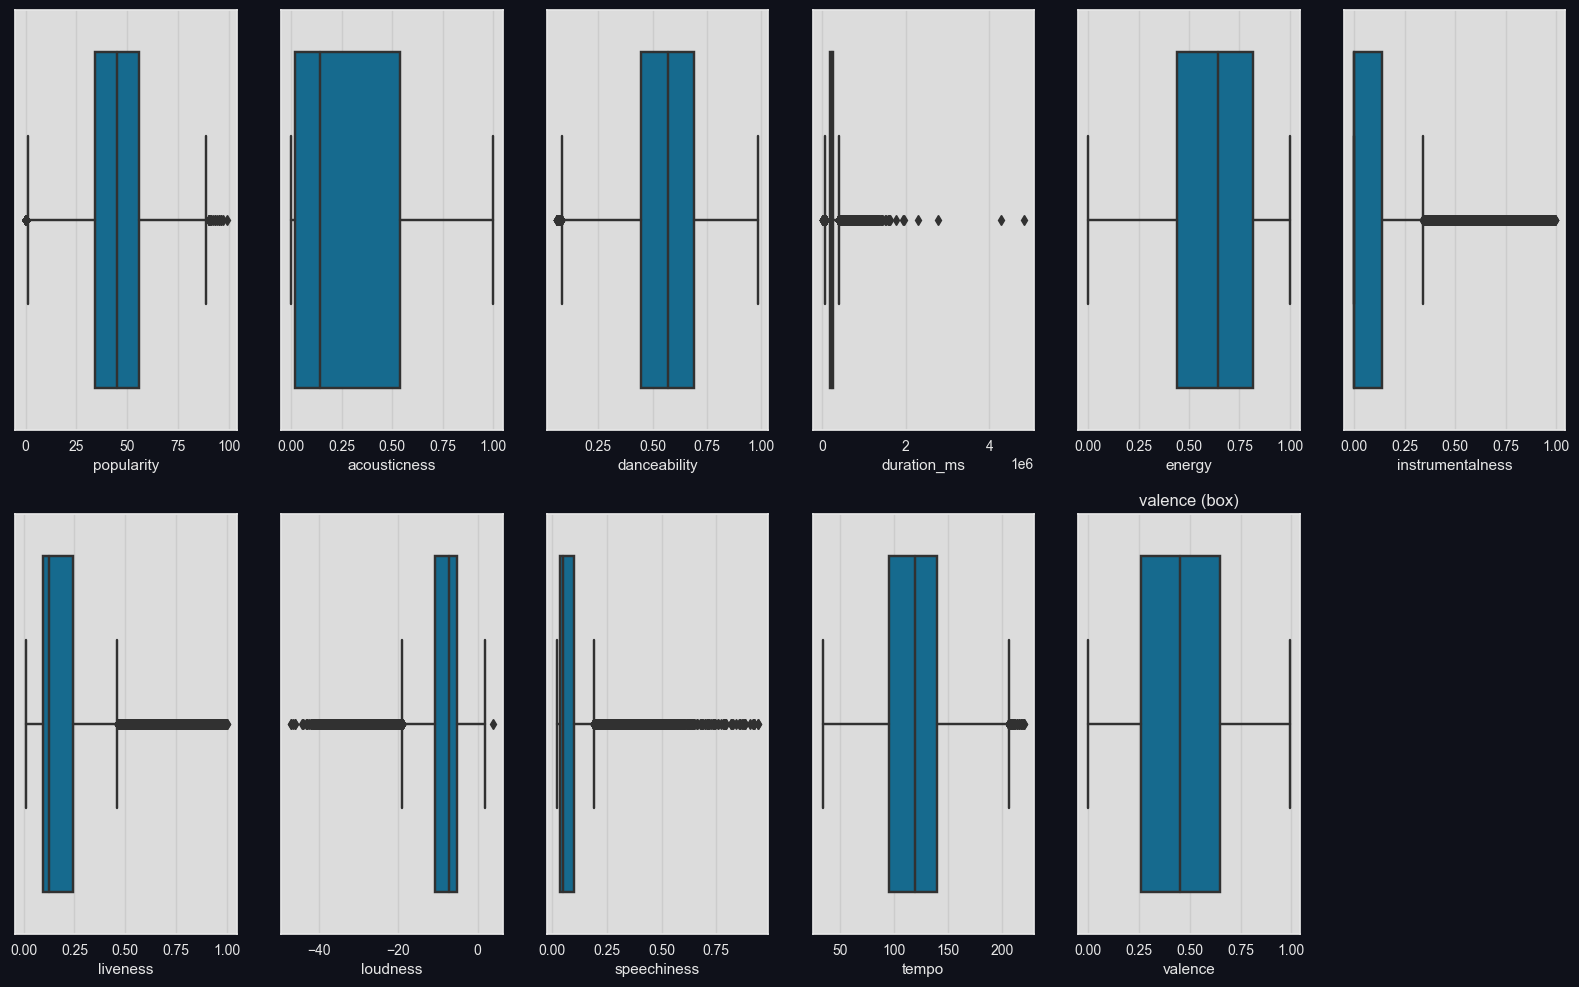

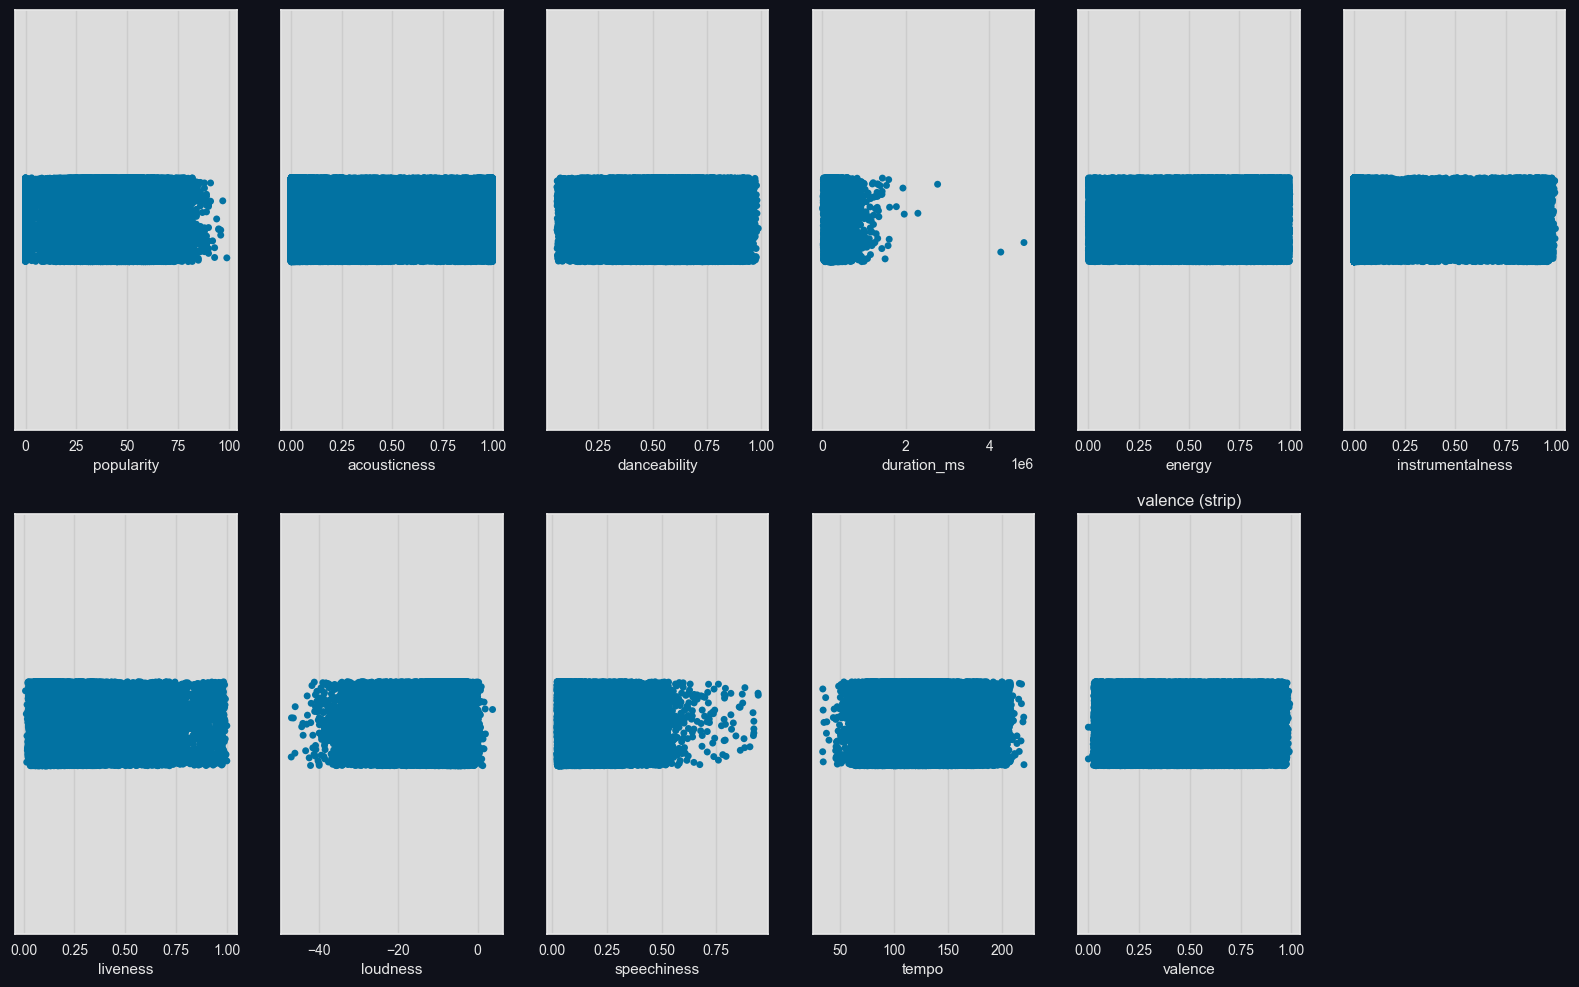

In [16]:
outlierplotboxALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotboxALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.boxplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (box)')
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [17]:
modelBM_IF, resultBM_IF, confmatrixBM_IF, f1BM_IF = modelTestProcess(df_outliertest_IF, getdummy=1)

Logistic Regression Model (F1 score) : 0.5289420692335385
Decision Tree Model (F1 score) : 0.44370417825324693
Random Forest Model (F1 score) : 0.5500204039684669
KNN Model (F1 score) : 0.46712937911671276
MLPC Model (F1 score) : 0.5714024337810822


#### **Local Outlier Factor**

In [18]:
from sklearn.neighbors import LocalOutlierFactor
dfOutlier_LOF = dfOutlier.copy()
dfOutlier_LOF = pd.get_dummies(dfOutlier_LOF, columns=['key','mode'], drop_first=True)
dfOutlier_LOF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,0,0,0,0,0,0,0,0,0,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,0,0,1,0,0,0,0,0,0,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,0,0,0,1,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,1,0,0,0,0,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,1,0,0,0,0,0,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,0,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,1,0,0,0,0,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,0,0,0,0,0,0,0,1,0,1


##### **Search for Hyperparameter**

In [19]:
# Impute missing values
dfOutlier_LOF_find = dfOutlier_LOF.copy()
X = dfOutlier_LOF_find.drop(['music_genre'], axis=1)
y = dfOutlier_LOF_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

KN_LOF_param = [{ 
              'n_neighbors' : range(10,60,10),
              # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              # 'leaf_size' : range(10,60,10),
              }]

KN_LOF_clf = KNeighborsClassifier(n_jobs=-1,algorithm='ball_tree')

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_LOF_clf = GridSearchCV(KN_LOF_clf, 
                        KN_LOF_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [20]:
# grid_KN_LOF_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_LOF_clf.best_params_)
# print("score :",grid_KN_LOF_clf.best_score_)

"""
Fitting 4 folds for each of 4 candidates, totalling 16 fits
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree'}
score : 0.4638039248476319

Fitting 4 folds for each of 5 candidates, totalling 20 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 20}
score : 0.4852892750123391
"""
pass

##### **Remove outlier**

In [21]:
X = dfOutlier_LOF.drop(['music_genre'], axis=1)
y = dfOutlier_LOF['music_genre']
colX = X.columns
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

clf_LOF = LocalOutlierFactor(n_neighbors=20, algorithm='ball_tree', n_jobs=-1)
clf_LOF.fit_predict(X)
lof_LOF  = clf_LOF.negative_outlier_factor_

In [22]:
thresh_LOF = np.quantile(lof_LOF, .03)
dfoutlier_LOF = dfOutlier_LOF[lof_LOF <= thresh_LOF]
dfNormal_LOF = dfOutlier_LOF[lof_LOF > thresh_LOF]
print(thresh_LOF)
dfNormal_LOF

-1.3476365914081732


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,0,0,0,0,0,0,0,0,0,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,0,0,1,0,0,0,0,0,0,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,0,0,0,1,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,1,0,0,0,0,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,1,0,0,0,0,0,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,0,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,1,0,0,0,0,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,0,0,0,0,0,0,0,1,0,1


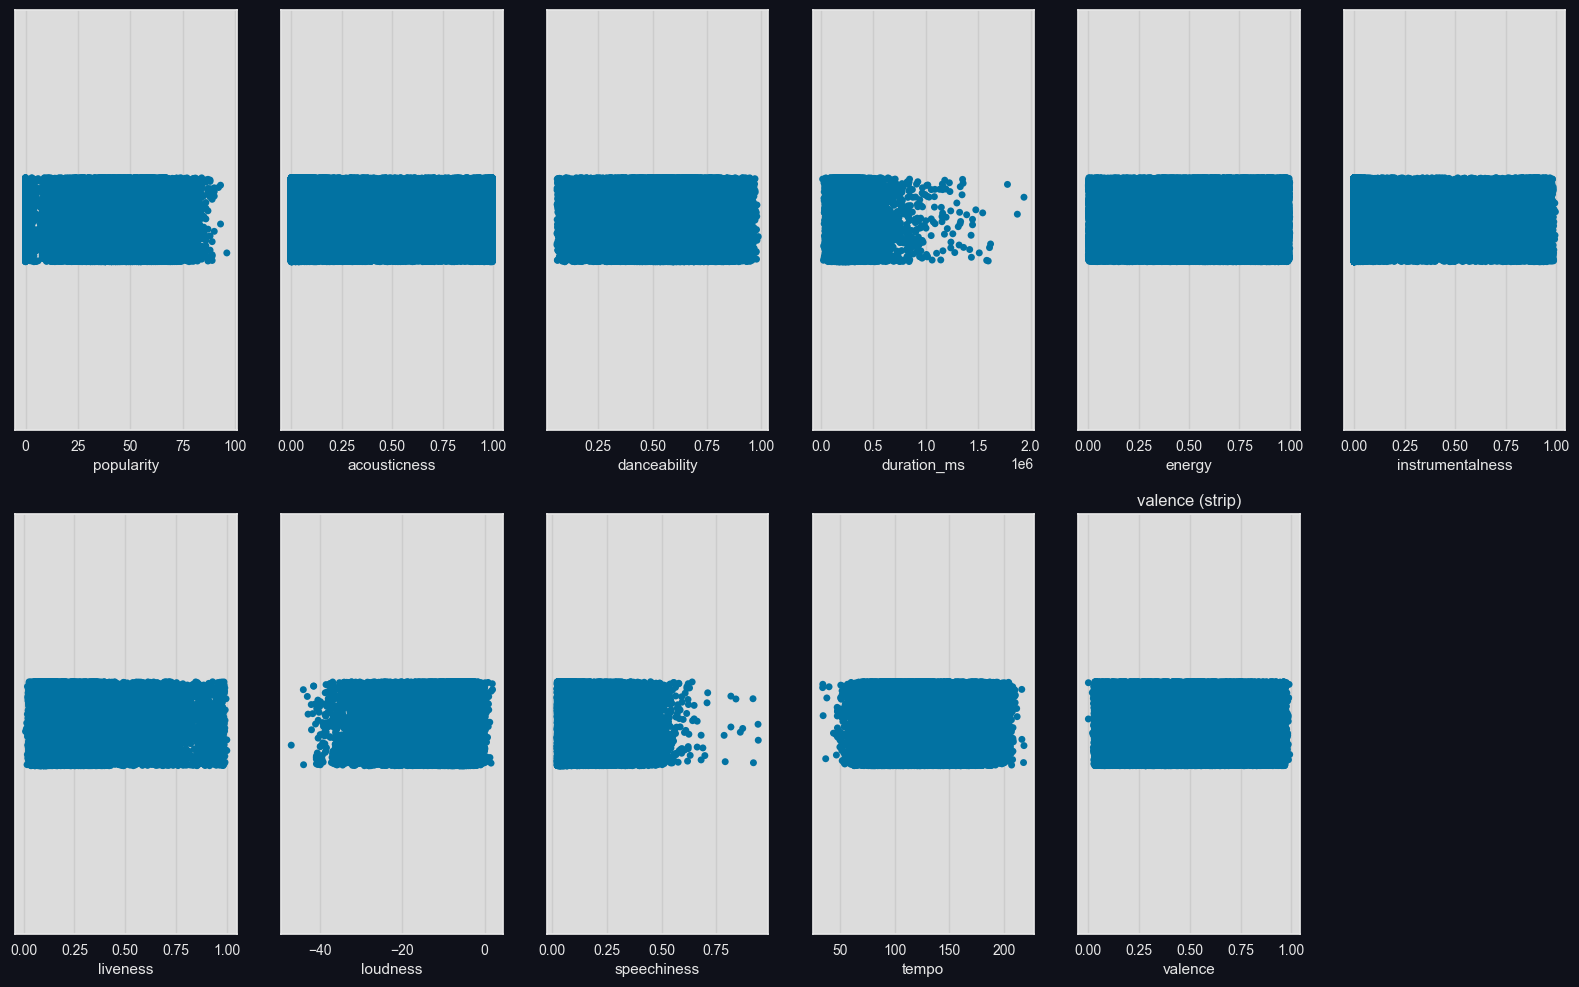

In [23]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfNormal_LOF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [24]:
modelBM_LOF, resultBM_LOF, confmatrixBM_LOF, f1BM_LOF = modelTestProcess(dfNormal_LOF, getdummy=0)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4709673156959691
MLPC Model (F1 score) : 0.582190201113514


#### **Nearest Neighbors**

In [25]:
# create arrays
dfnbrs = dfOutlier.copy()
dfnbrsOrig = dfnbrs.copy()
# Unsupervised learning we consider all features even the target
X = pd.get_dummies(dfnbrs, columns=['key','mode','music_genre'], drop_first=True)
X

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,mode_Minor,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,1,0,0,0,0,1,0,0,0,0
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,1,0,0,0,0,1,0,0,0,0
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,1,0,0,0,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,0,0,0,0,1,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,0,0,0,0,0,1,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,1,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,0,0,0,0,1,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,1,0,0,0,0,0,1,0,0,0


โดยจะใช้ HYPERPARAMETER ที่ได้จาก Section ที่แล้ว คือ n_neighbors = 20, algorithm = 'ball_tree'

##### **Remove outlier**

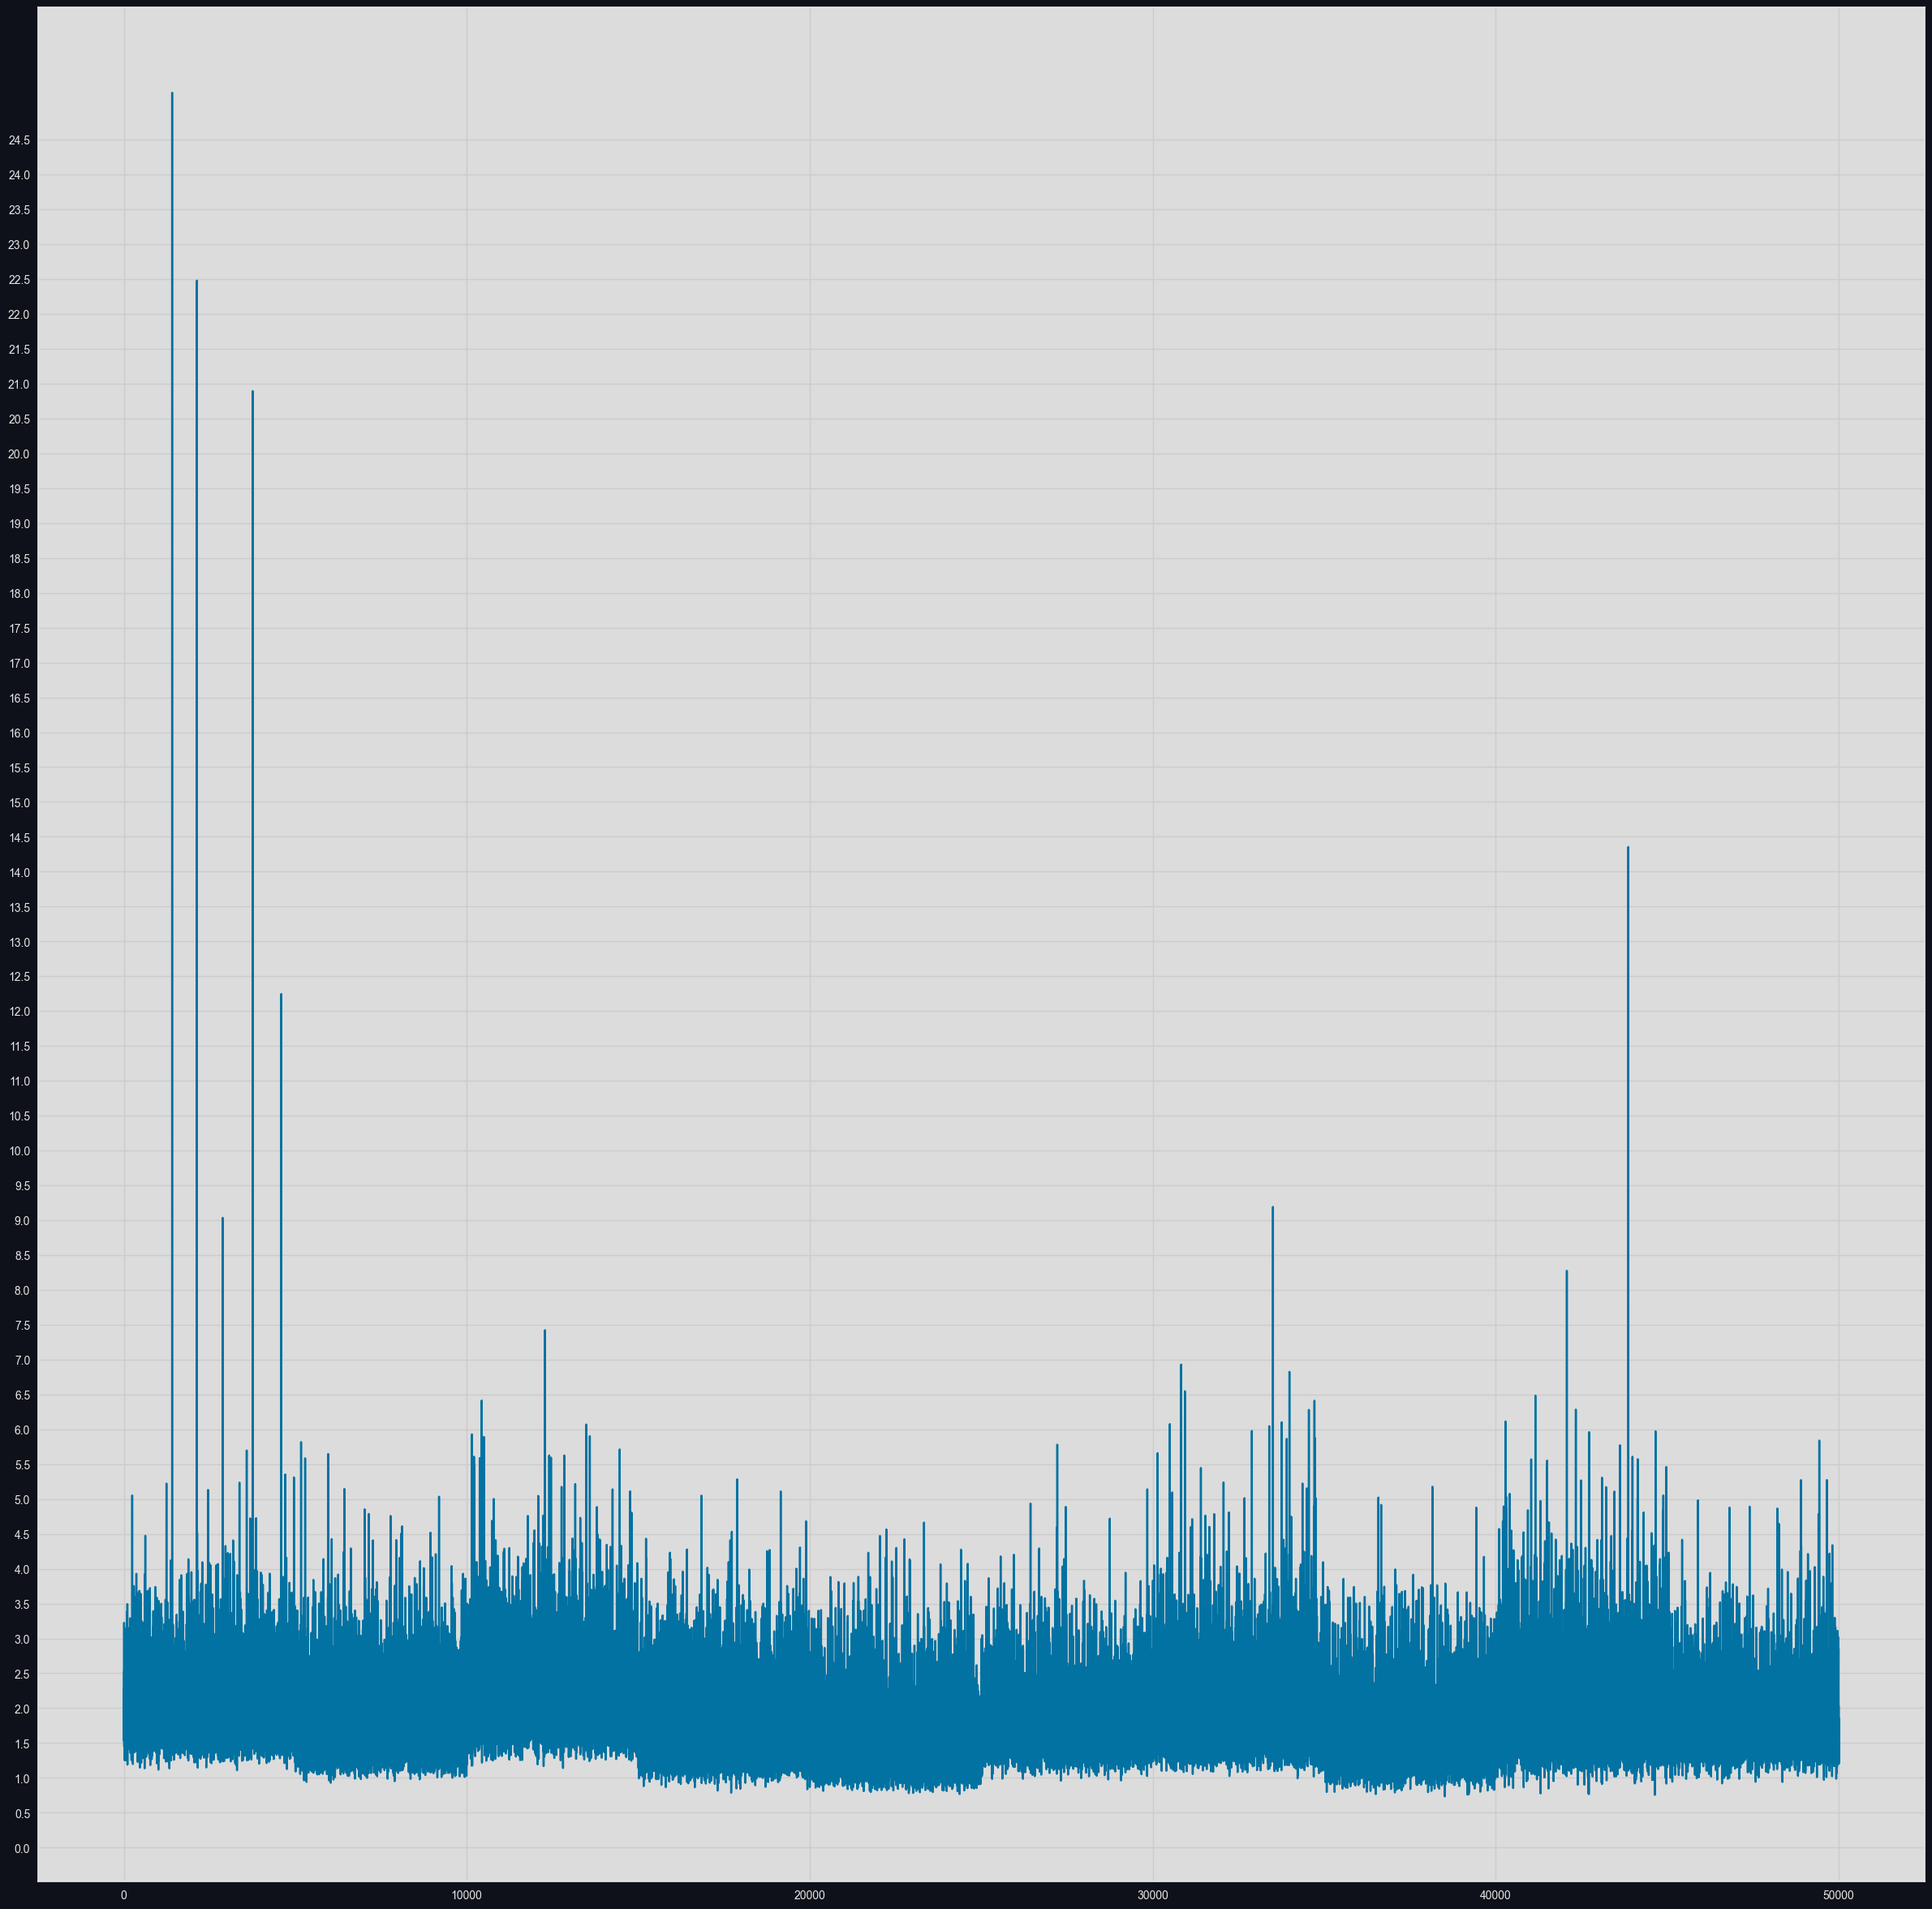

In [26]:
# instantiate model
scaler = StandardScaler()
X = scaler.fit_transform(X)
nbrs = NearestNeighbors(n_jobs=-1,n_neighbors=20,algorithm='ball_tree').fit(X)
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
anomalyPlot, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.set_yticks(np.arange(0, 25, 0.5))
ax.plot(distances.mean(axis =1))

In [27]:
# visually determine cutoff values > 2.8
outlier_index = np.where(distances.mean(axis = 1) > 2.8)
# filter outlier values
outlier_values = dfnbrsOrig.iloc[outlier_index]
outlier_values

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
10,30.0,0.85500,0.607,170463.000000,0.158,0.000000,0.106,-13.787,0.0345,57.528000,0.307,F#,Minor,Electronic
16,59.0,0.13600,0.336,216077.666667,0.746,0.000000,0.737,-4.315,0.0685,151.756000,0.210,C#,Minor,Electronic
20,44.0,0.00804,0.516,241877.000000,0.920,0.614000,0.801,-4.370,0.0942,145.027000,0.332,A,Minor,Electronic
43,43.0,0.16900,0.685,219436.333333,0.909,0.000663,0.942,-7.627,0.0430,119.978000,0.962,C,Major,Electronic
60,27.0,0.21600,0.626,337091.000000,0.362,0.867000,0.681,-14.892,0.0479,109.948000,0.107,C,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49880,49.0,0.01100,0.431,528880.000000,0.898,0.001150,0.523,-4.233,0.1660,96.701000,0.192,C#,Minor,Hip-Hop
49900,54.0,0.04200,0.688,185747.000000,0.723,0.874000,0.196,-5.259,0.0463,171.774000,0.959,A,Minor,Hip-Hop
49959,59.0,0.08470,0.929,215200.000000,0.737,0.000000,0.861,-6.424,0.1020,126.653667,0.886,G#,Major,Hip-Hop
49977,58.0,0.72300,0.541,197721.000000,0.399,0.000060,0.111,-10.414,0.1310,203.893000,0.392,B,Major,Hip-Hop


In [28]:
dropOutliers = outlier_index[0].tolist()
dfnbrsOrig.drop(dropOutliers, axis=0, inplace=True)
dfnbrsOrig.reset_index(drop=True, inplace=True)
dfnbrsOrig

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46472,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
46473,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
46474,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
46475,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


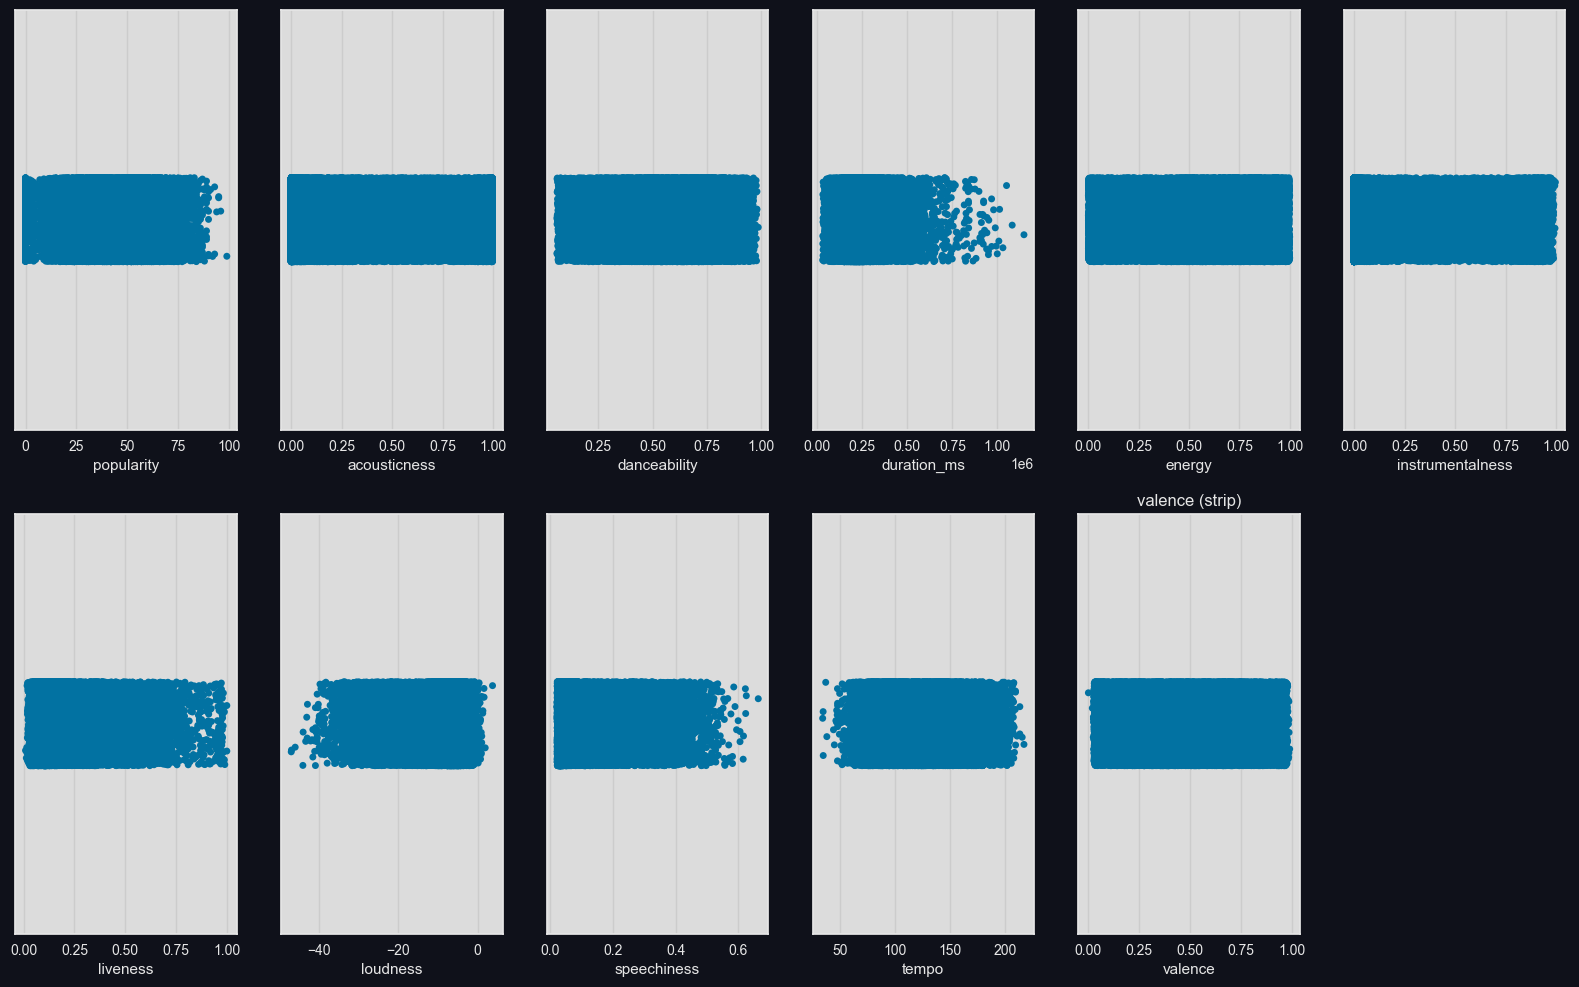

In [29]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfnbrsOrig[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [30]:
modelBM_KN, resultBM_KN, confmatrixBM_KN, f1BM_KN = modelTestProcess(dfnbrsOrig, getdummy=1)

Logistic Regression Model (F1 score) : 0.5391570061625844
Decision Tree Model (F1 score) : 0.44469774223072245
Random Forest Model (F1 score) : 0.5567616271692278
KNN Model (F1 score) : 0.4779681649136388
MLPC Model (F1 score) : 0.5867948169999857


In [31]:
"""
BM
{'Logistic Regression Model': 0.524447965191827,
 'Decision Tree Model': 0.43945745895900645,
 'Random Forest Model': 0.5495947325317898,
 'KNN Model': 0.47201620184508275,
 'MLPC Model': 0.5820716052140181}

 K=5 th=3.5
 {'Logistic Regression Model': 0.5267810382941709,
 'Decision Tree Model': 0.44051382014335133,
 'Random Forest Model': 0.553135221178713,
 'KNN Model': 0.47181105767624826,
 'MLPC Model': 0.5644229849392003}

 K=20 th=2.5
 {'Logistic Regression Model': 0.5534657308220577,
 'Decision Tree Model': 0.45364463234145963,
 'Random Forest Model': 0.5591870916498062,
 'KNN Model': 0.4828599318951609,
 'MLPC Model': 0.5966668901650811}

  K=20 th=2.8
 {'Logistic Regression Model': 0.5391570061625844,
 'Decision Tree Model': 0.4440435845051865,
 'Random Forest Model': 0.5567451105220543,
 'KNN Model': 0.4779681649136388,
 'MLPC Model': 0.5853447432208643}

 K=20 th=3.0
{'Logistic Regression Model': 0.5416241410065534,
 'Decision Tree Model': 0.4450136318014417,
 'Random Forest Model': 0.5503797141498078,
 'KNN Model': 0.47676748749978265,
 'MLPC Model': 0.5778236970506728}

"""
pass

#### **Conclusion**

babababadbaba

In [32]:
dfOutlier_res = dfOutlier.copy()
dfOutlier_res = dfOutlier_res[lof_LOF > thresh_LOF]
dfOutlier_res.reset_index(drop=True, inplace=True)
dfOutlier_res

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48495,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
48496,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
48497,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
48498,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


In [34]:
dfOutlier_res.to_csv('Data/dfOutlier_res.csv', index=False)

### **Data Transformation**

In [35]:
df = pd.read_csv('Data/dfOutlier_res.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

##### **Performance Benchmark**

In [36]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4709673156959691
MLPC Model (F1 score) : 0.582190201113514


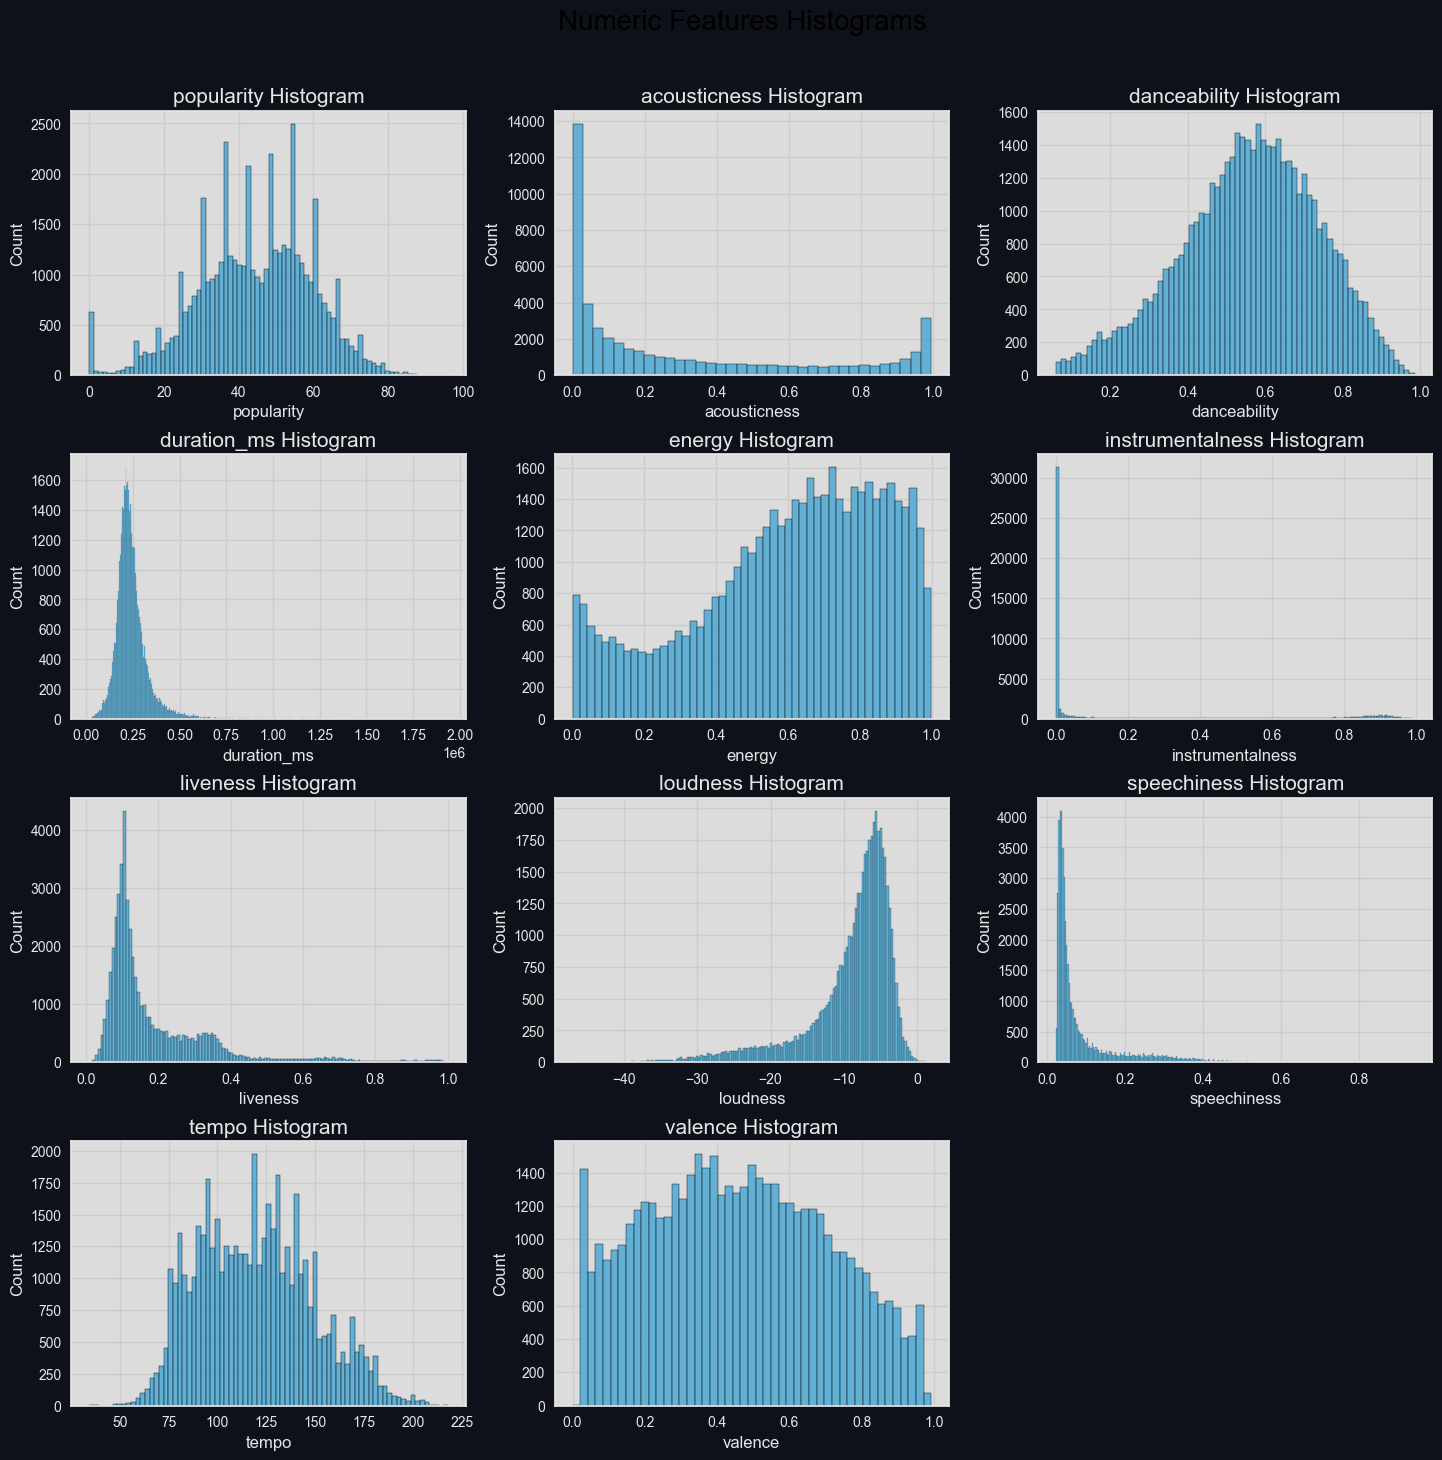

In [37]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

#### **acousticness Feature**

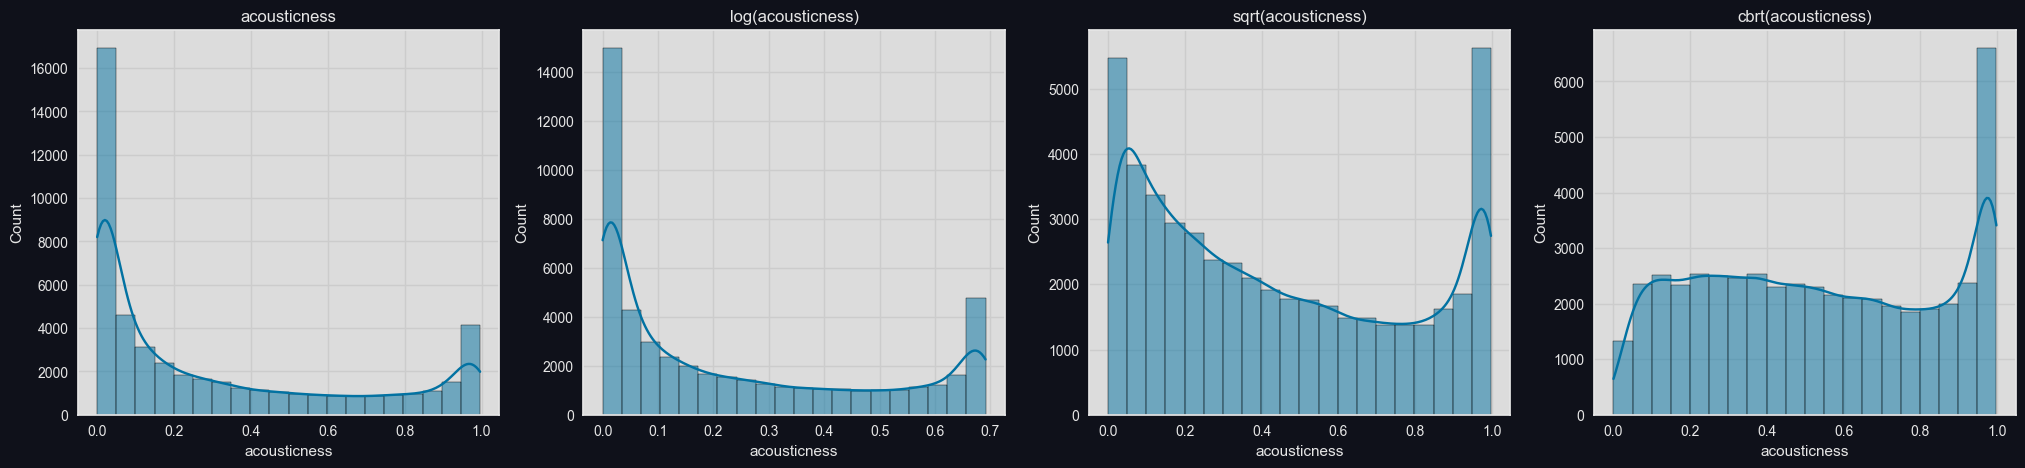

In [38]:
acousticness_base = df['acousticness']
acousticness_log = np.log(df["acousticness"]+1)
acousticness_sqrt = np.sqrt(df["acousticness"])
acousticness_cbrt = np.cbrt(df["acousticness"])
title = ['acousticness', 'log(acousticness)', 'sqrt(acousticness)', 'cbrt(acousticness)']
acousticnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([acousticness_base, acousticness_log, acousticness_sqrt, acousticness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **duration_ms Feature**

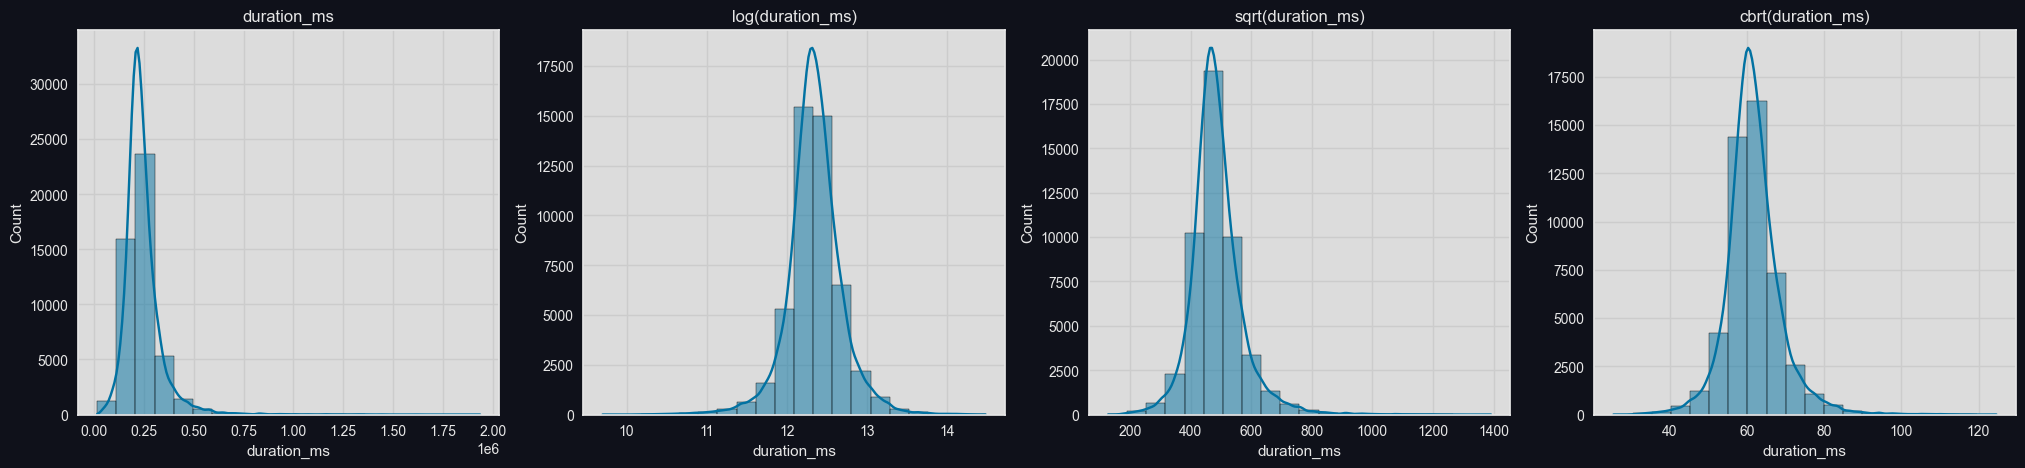

In [39]:
duration_ms_base = df['duration_ms']
duration_ms_log = np.log(df["duration_ms"])
duration_ms_sqrt = np.sqrt(df["duration_ms"])
duration_ms_cbrt = np.cbrt(df["duration_ms"])
title = ['duration_ms', 'log(duration_ms)', 'sqrt(duration_ms)', 'cbrt(duration_ms)']
duration_mstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([duration_ms_base, duration_ms_log, duration_ms_sqrt, duration_ms_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [45]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_log

modelBM_Duration_log, resultBM_Duration_log, confmatrixBM_Duration_log, f1BM_Duration_log = modelTestProcess(dfDuration, getdummy=1)

Logistic Regression Model (F1 score) : 0.533729915477468
Decision Tree Model (F1 score) : 0.4436566732328976
Random Forest Model (F1 score) : 0.5512512049916017
KNN Model (F1 score) : 0.4737041015601774
MLPC Model (F1 score) : 0.5827114233497143


In [46]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_cbrt

modelBM_Duration_cbrt, resultBM_Duration_cbrt, confmatrixBM_Duration_cbrt, f1BM_Duration_cbrt = modelTestProcess(dfDuration, getdummy=1)

Logistic Regression Model (F1 score) : 0.5340660741918921
Decision Tree Model (F1 score) : 0.4435410451989476
Random Forest Model (F1 score) : 0.5511484530893378
KNN Model (F1 score) : 0.47334517401172793
MLPC Model (F1 score) : 0.5816618263303287


#### **instrumentalness Feature**

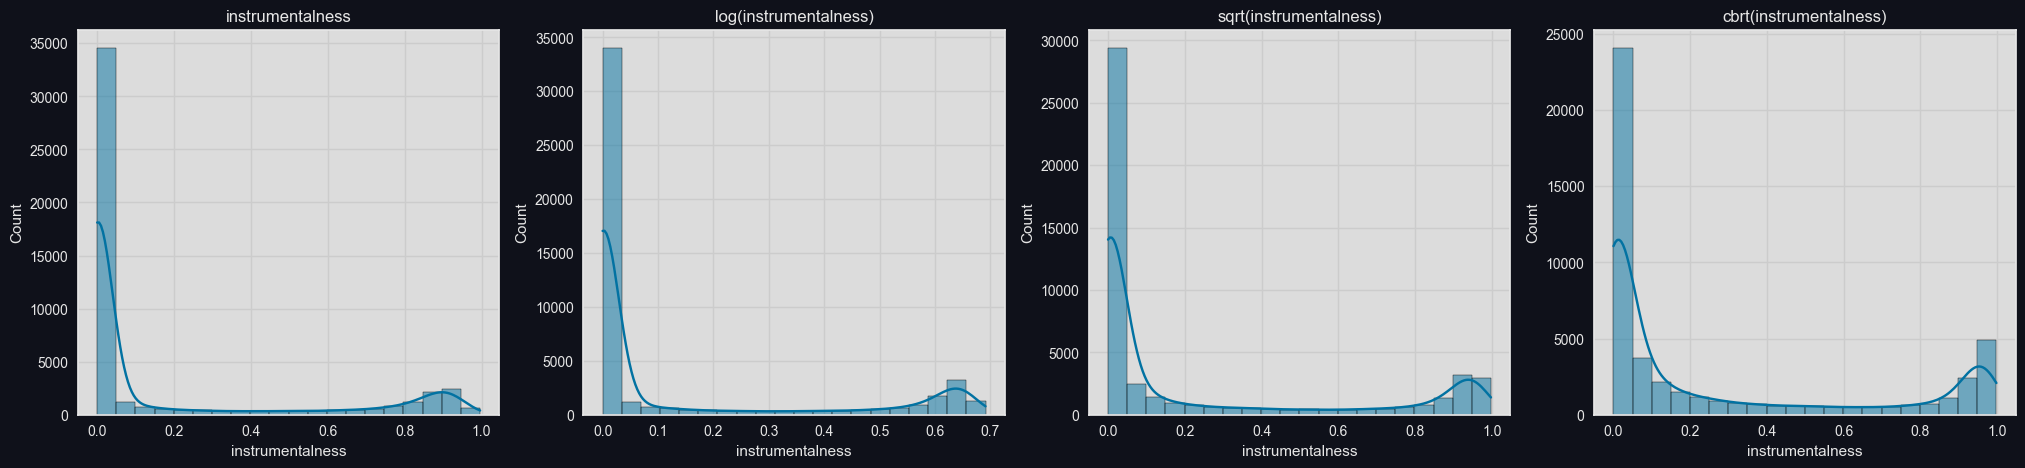

In [40]:
instrumentalness_base = df['instrumentalness']
instrumentalness_log = np.log(df["instrumentalness"]+1)
instrumentalness_sqrt = np.sqrt(df["instrumentalness"])
instrumentalness_cbrt = np.cbrt(df["instrumentalness"])
title = ['instrumentalness', 'log(instrumentalness)', 'sqrt(instrumentalness)', 'cbrt(instrumentalness)']
instrumentalnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([instrumentalness_base, instrumentalness_log, instrumentalness_sqrt, instrumentalness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **liveness Feature**

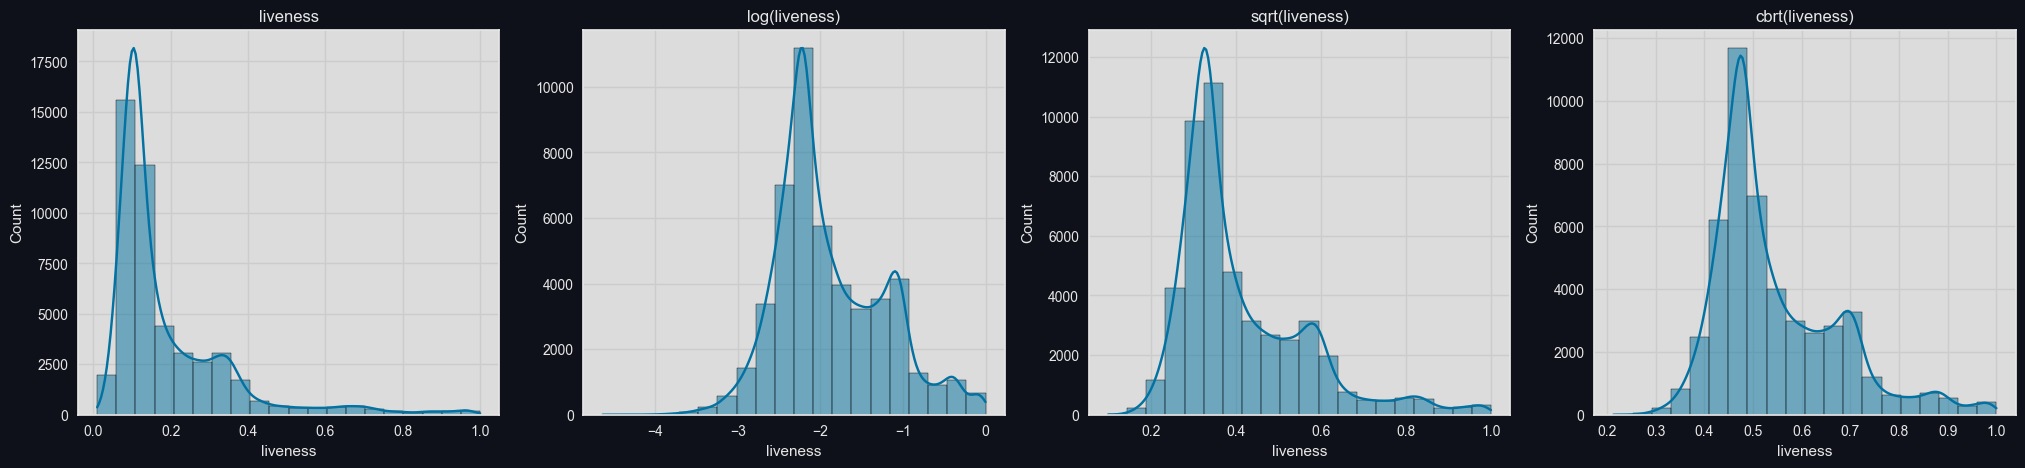

In [41]:
liveness_base = df['liveness']
liveness_log = np.log(df["liveness"])
liveness_sqrt = np.sqrt(df["liveness"])
liveness_cbrt = np.cbrt(df["liveness"])
title = ['liveness', 'log(liveness)', 'sqrt(liveness)', 'cbrt(liveness)']
livenesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([liveness_base, liveness_log, liveness_sqrt, liveness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [47]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_log

modelBM_Liveness_log, resultBM_Liveness_log, confmatrixBM_Liveness_log, f1BM_Liveness_log = modelTestProcess(dfLiveness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5352213530678591
Decision Tree Model (F1 score) : 0.44385863942657255
Random Forest Model (F1 score) : 0.5512122179361562
KNN Model (F1 score) : 0.4680461766899694
MLPC Model (F1 score) : 0.5798518690845943


In [48]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_cbrt

modelBM_Liveness_cbrt, resultBM_Liveness_cbrt, confmatrixBM_Liveness_cbrt, f1BM_Liveness_cbrt = modelTestProcess(dfLiveness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5360678083215004
Decision Tree Model (F1 score) : 0.44367396452787294
Random Forest Model (F1 score) : 0.5512484972024289
KNN Model (F1 score) : 0.4699381115358704
MLPC Model (F1 score) : 0.5842755856272527


#### **loudness Feature**

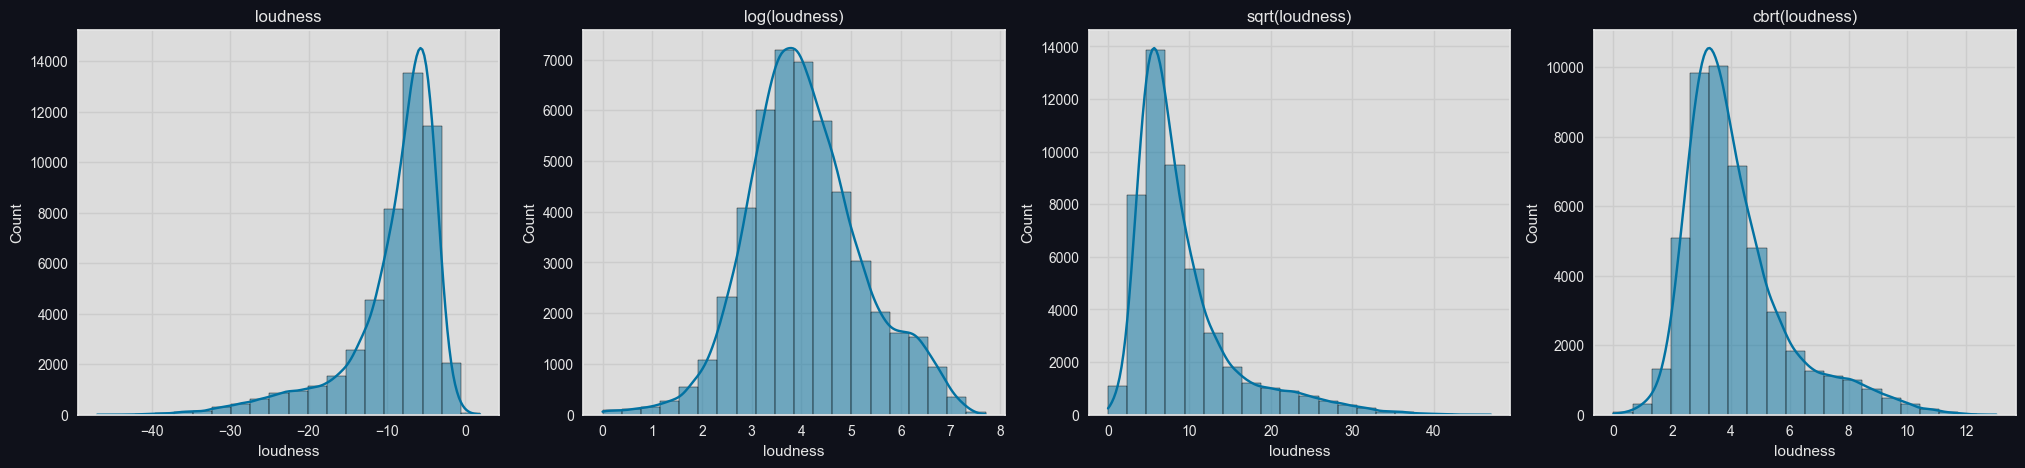

In [42]:
# Left skewed data can be transformed by taking the square first
loudness_base = df['loudness']
X = np.square(df["loudness"])
loudness_log = np.log(X+1)
loudness_sqrt = np.sqrt(X)
loudness_cbrt = np.cbrt(X)
title = ['loudness', 'log(loudness)', 'sqrt(loudness)', 'cbrt(loudness)']
loudnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([loudness_base, loudness_log, loudness_sqrt, loudness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [49]:
dfLoudness = df.copy()
dfLoudness['loudness'] = loudness_log

modelBM_Loudness_log, resultBM_Loudness_log, confmatrixBM_Loudness_log, f1BM_Loudness_log = modelTestProcess(dfLoudness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5380658637343865
Decision Tree Model (F1 score) : 0.44199705038660936
Random Forest Model (F1 score) : 0.5432208696618277
KNN Model (F1 score) : 0.47757514300049714
MLPC Model (F1 score) : 0.5846061770571997


#### **speechiness Feature**

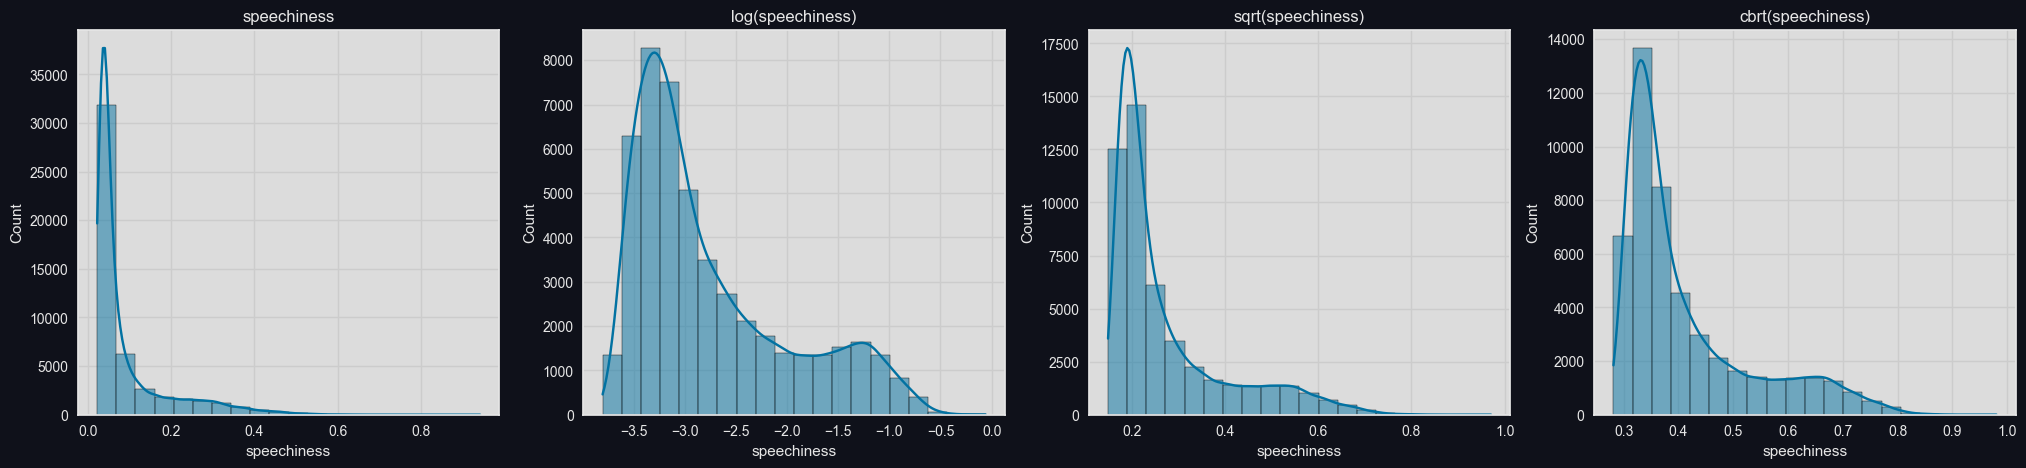

In [43]:
speechiness_base = df['speechiness']
speechiness_log = np.log(df["speechiness"])
speechiness_sqrt = np.sqrt(df["speechiness"])
speechiness_cbrt = np.cbrt(df["speechiness"])
title = ['speechiness', 'log(speechiness)', 'sqrt(speechiness)', 'cbrt(speechiness)']
speechinesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([speechiness_base, speechiness_log, speechiness_sqrt, speechiness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **Mix Feature**

In [50]:
dfMix = df.copy()
dfMix['duration_ms'] = duration_ms_log
dfMix['liveness'] = liveness_cbrt
dfMix['loudness'] = loudness_log

modelBM_Mix, resultBM_Mix, confmatrixBM_Mix, f1BM_Mix = modelTestProcess(dfMix, getdummy=1)

Logistic Regression Model (F1 score) : 0.5346875385993367
Decision Tree Model (F1 score) : 0.4423336541109584
Random Forest Model (F1 score) : 0.5431838161763447
KNN Model (F1 score) : 0.4737741259685333
MLPC Model (F1 score) : 0.5807543221261556


#### **Conclusion**

Not Good